# Cars cost determination

1. The customer is a service for selling used cars.
2. The end result is an app where you can find out the market value of your car. 
3. It is necessary to build a model that manages to define it. 
4. Specifications, equipment and prices of other cars are available.

Criteria that are important for the customer:
- quality of prediction;
- model training time;
- model prediction time.

RMSE is recommended as a quality metric with a desired value of RMSE < 2500.

In [1]:
!pip install distinctipy colorcet pgeocode geopy xgboost

In [2]:
!pip install seaborn --upgrade

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import lightgbm as lgb
import sklearn
import pgeocode
import catboost
import xgboost

from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

In [4]:
sb.__version__

'0.13.2'

Seaborn 0.12.0+ is needed.

## Primary data analysis

In [5]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [6]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Features: <a id='features'></a>
- DateCrawled — date of downloading the questionnaire from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — car model
- Kilometer — mileage (km)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — car brand
- Repaired — whether or not the car has been repaired
- DateCreated — questionnaire creation date
- NumberOfPictures — number of photos of the vehicle
- PostalCode — postal code of the questionnaire owner (user)
- LastSeen — date of last user activity

Target:
- Price — price (euro)

The plan for the analysis is as follows:
1. Construct bar charts for the qualitative variables
2. Construct histograms for quantitative variables
3. Construct whisker boxes for quantitative variables
4. View price trends by day
4. Estimate the number of missing values
5. Count duplicates
6. Estimate the impact of emissions

### Qualitative variables

In [7]:
data.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Let's see what values occur in the columns:
- VehicleType
- Gearbox
- Model
- RegistrationMonth
- FuelType
- Brand
- Repaired
- PostalCode

In [8]:
def barplot_from_counts(series, by_index=False):
    from matplotlib import patches as mpatches
    from matplotlib.ticker import MaxNLocator

    if len(series) <= 9:
        colors = plt.colormaps.get_cmap('Set1').colors
    else:
        import colorcet
        colors = colorcet.glasbey[:len(series)] 
        # import distinctipy
        # colors = distinctipy.get_colors(len(series), pastel_factor=0.57)
        
    if by_index:
        series = series.sort_index()
    
    series.index = series.index.map(str)
    legend = []    
    for row in range(len(series)):
        legend.append(mpatches.Patch(color=colors[row], 
            label='{}: {}'.format(series.index[row], series.iloc[row])))
    fig, ax = plt.subplots(figsize=(12, 9))
    plt.bar(x=series.index, 
            height=series.values, 
            color=colors)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(series.name, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(handles=legend, fontsize=14)
    plt.show()

#### Vehicle body type

In [9]:
data['VehicleType'].isna().sum()

37490

In [10]:
data['VehicleType'].isna().sum() / len(data)

0.1057936783409384

10.57% of cars have an unknown body type.

Let's look at the rest of them.

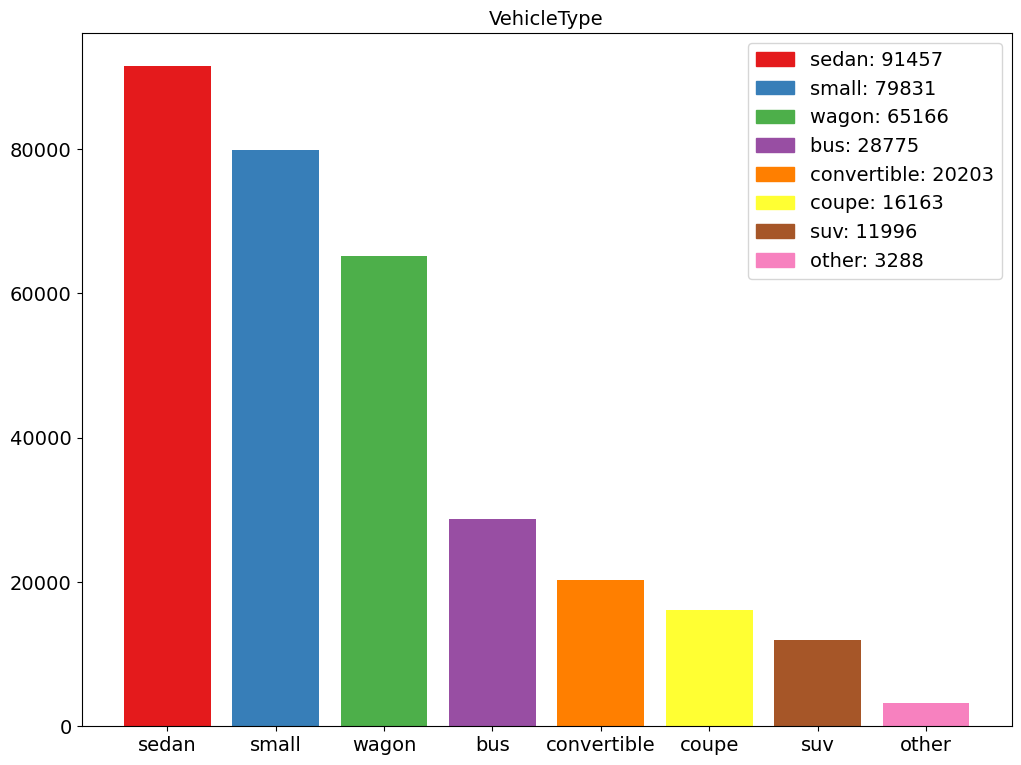

In [11]:
barplot_from_counts(data['VehicleType'].value_counts())

There is little difference between other and NaN. Let's replace missing values with "other" at the preprocessing stage.

#### Gearbox

In [12]:
data['Gearbox'].isna().sum()

19833

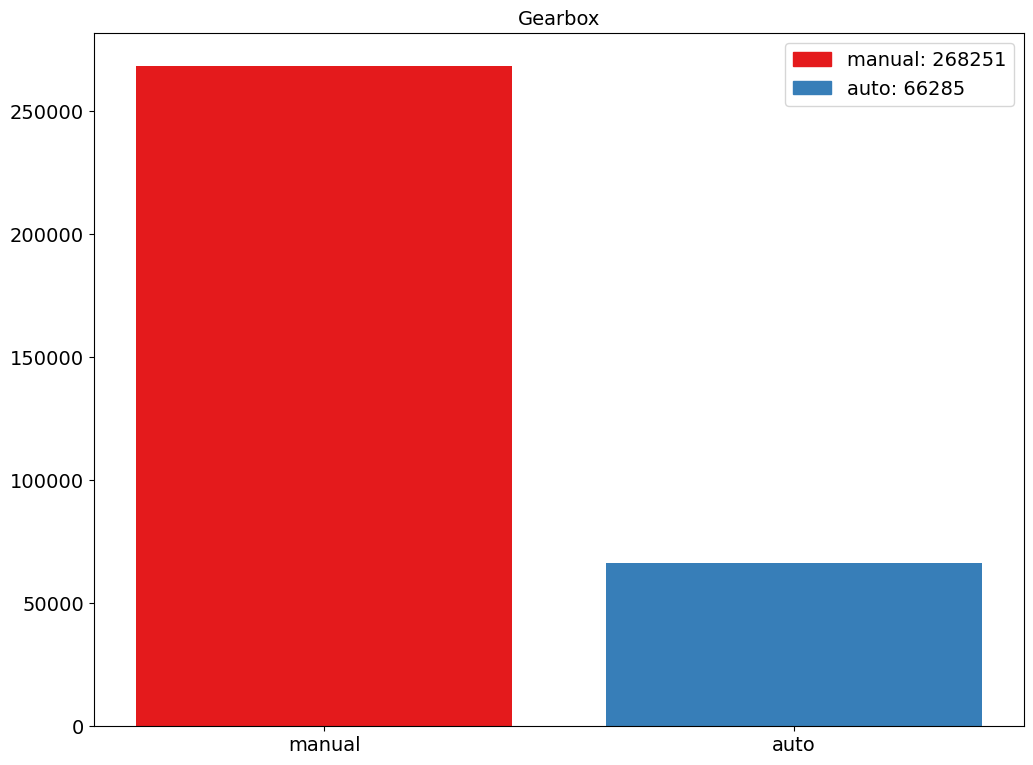

In [13]:
barplot_from_counts(data['Gearbox'].value_counts())

This is a significant imbalance. We can try to take it into account at the stage of preparing samples. If it takes too long to work on the whole dataset.

#### Car model

In [14]:
data['Model'].isna().sum()

19705

In [15]:
data['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

There are 250 models in total. Here also all the missing values will pass to the "other" category. I wonder if these models are unambiguously categorized by brand.

In [16]:
data.loc[data['Model'] == 'golf']['Brand'].unique()

array(['volkswagen'], dtype=object)

All cars of the golf model belong to the Volkswagen brand. At the EDA stage we will have to check this for the others as well.

#### Month of registration

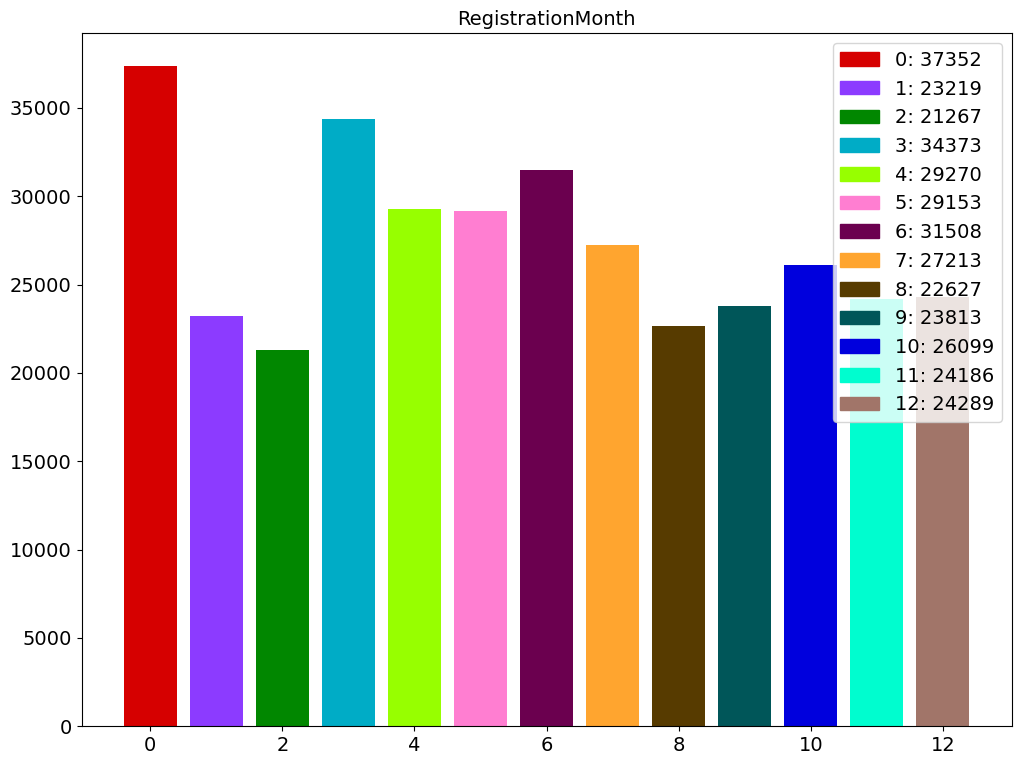

In [17]:
barplot_from_counts(data['RegistrationMonth'].value_counts(), by_index=True)

Maybe there is some seasonal logic here, but what is important is how the month affects the price. What is really puzzling is that there are 13 months. Apparently month 0 is an unspecified one.

#### Fuel type

In [18]:
data['FuelType'].isna().sum()

32895

In [19]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Here it is not so clear that missing values should be transferred to the category "other". Nevertheless, let's do it. It will be necessary to check how often the values of the category "other" will coincide across the lines.

#### Car brand

In [20]:
data['Brand'].isna().sum()

0

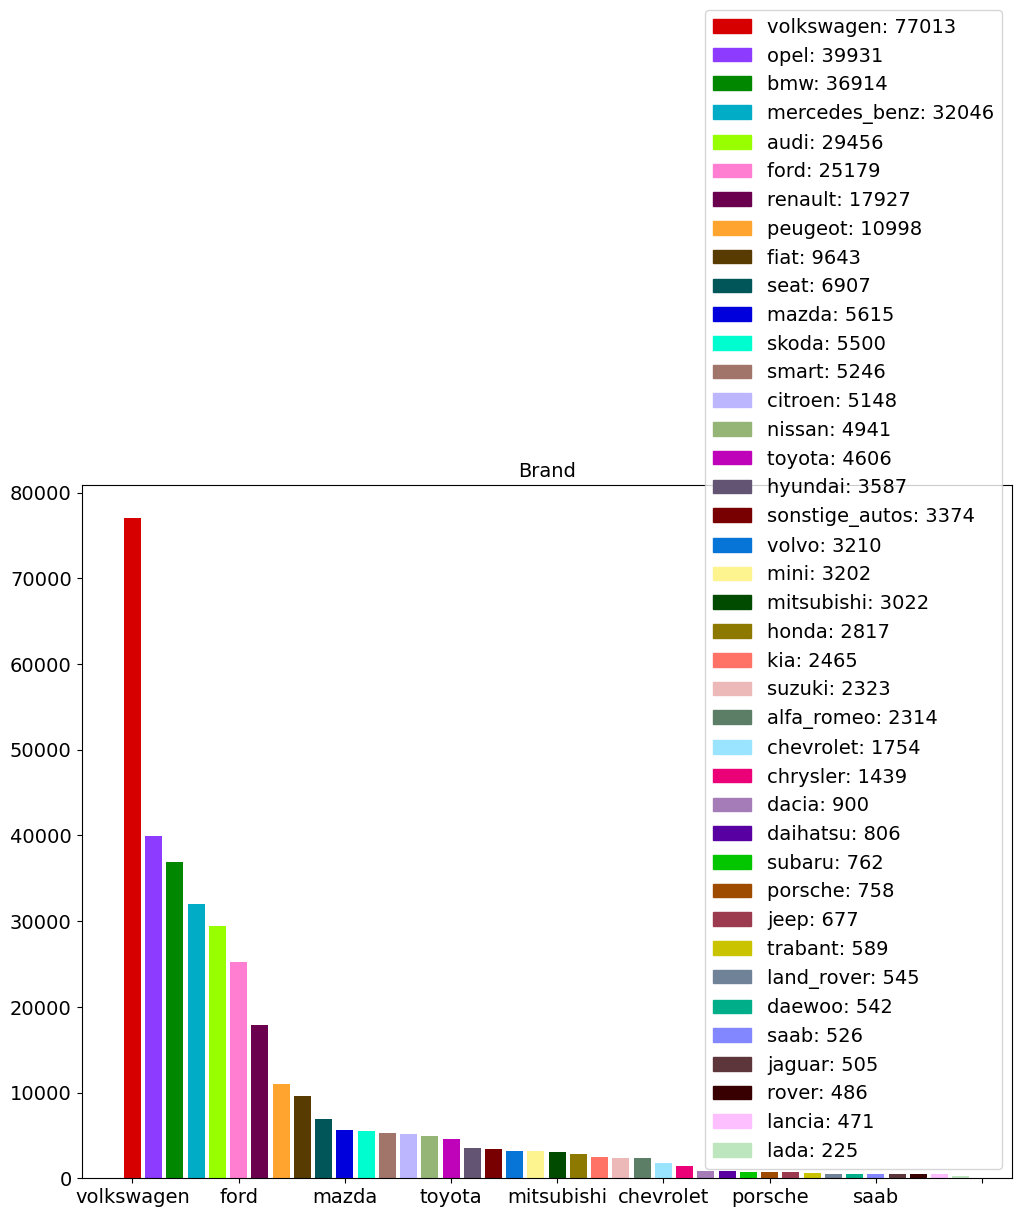

In [21]:
barplot_from_counts(data['Brand'].value_counts())

Volkswagen is clearly in the lead. Das auto.

#### Breakdown history

In [22]:
data['Repaired'].isna().sum()

71154

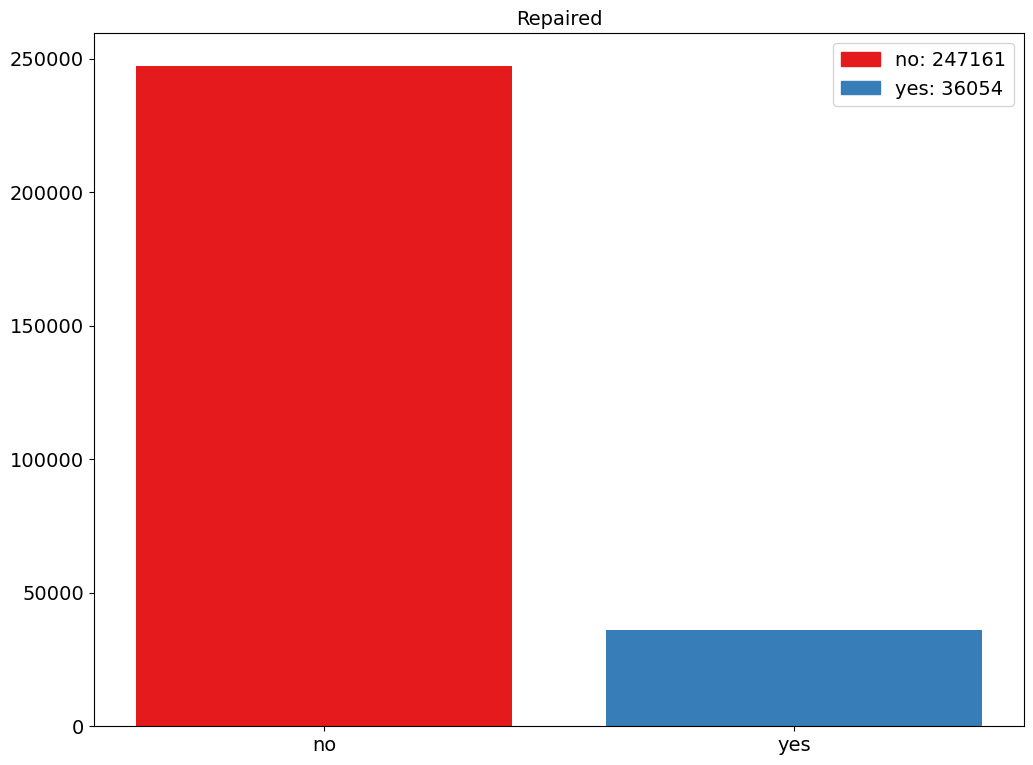

In [23]:
barplot_from_counts(data['Repaired'].value_counts())

I wonder who checks this. Because if the owners themselves indicate, these numbers may not reflect reality.

#### Postal code

Despite the fact that there are a lot of values here, it is still a categorical variable. There is no way to make a bar chart, so let's try to estimate it without a graph.

In [24]:
data['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: PostalCode, Length: 8143, dtype: int64

The distribution is clearly uneven. On the other hand, different numbers of people with different numbers of cars may live in the areas of two zip codes.

Maybe we can group it by area?

In [25]:
%%time
list_of_states = []
for postal_code in ['10115']:
    for country in pgeocode.COUNTRIES_VALID:
        nomi = pgeocode.Nominatim(country)
        if not pd.isna(nomi.query_postal_code(postal_code)['state_name']):
            list_of_states.append(nomi.query_postal_code(postal_code)['state_name'])
list_of_states

/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/pgeocode.py:216: UserWarning: The Argentina data file contains 4-digit postal codes which were replaced with a new system in 1999.
  warnings.warn(


CPU times: user 6.39 s, sys: 896 ms, total: 7.29 s
Wall time: 7.54 s


['Berlin', 'Harju maakond', '경기도', 'Western Province', 'New York']

Apparently not. It is not clear which country to put in the category.

### Quantitative variables

In [26]:
data.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Let's look at the columns
- Price
- RegistrationYear
- Power
- Kilometer
- NumberOfPictures

In [27]:
def hist_from_series(series):
    # sb.set(style="ticks")
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12, 9), 
                                      gridspec_kw={"height_ratios": (.20, .8)})
    box = sb.boxplot(x=series, ax=ax_box)
    hist = sb.histplot(x=series, ax=ax_hist)
    
    box.set_xlabel(None)
    box.tick_params(left=False, labelsize=15)
    sb.despine(ax=ax_box, left=False, right=False, top=False, bottom=True)
    
    hist.set_xlabel(series.name, fontsize=15)
    hist.set_ylabel('Count', fontsize=15)
    hist.tick_params(labelsize=15)
    sb.despine(ax=ax_hist, right=False)
    
    plt.show()

#### Price

In [28]:
series = data['Price']

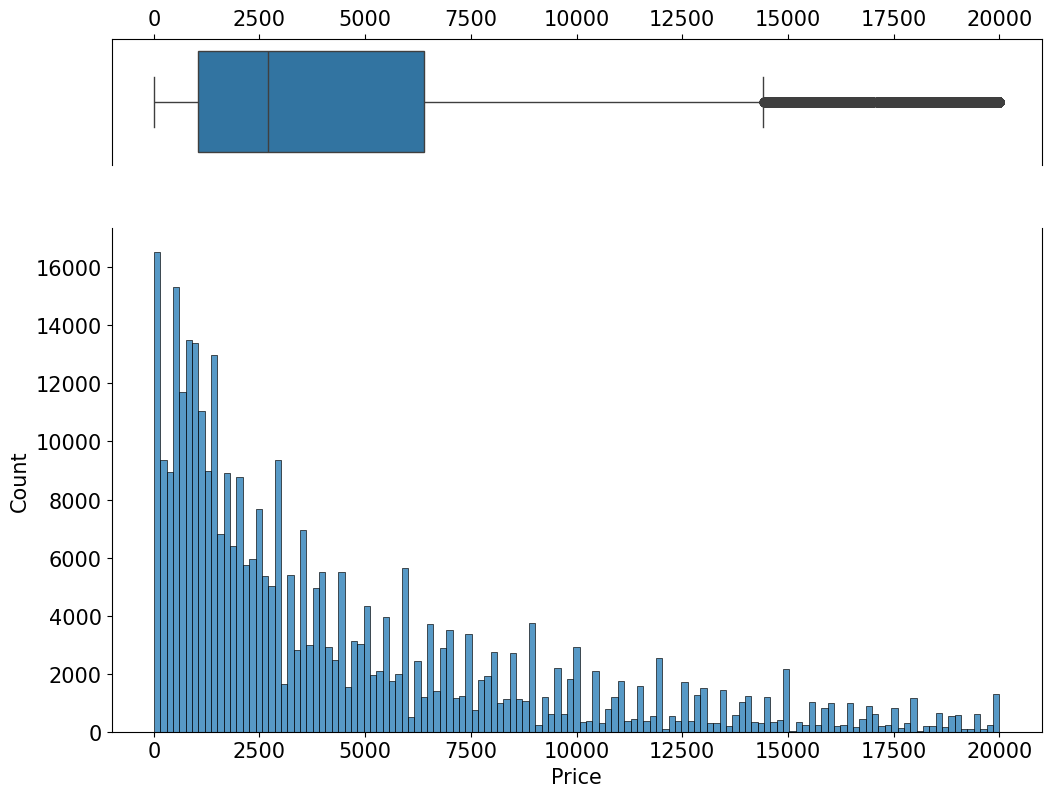

In [29]:
hist_from_series(series)

In [30]:
series.value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Those zeros will have to be replaced with something. The median of the year of manufacture or something. On the other hand, 11.000 is about 3%, we can throw it away.

#### The year of registration

In [31]:
series = data['RegistrationYear']

In [32]:
series.value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

There are clearly anomalies here.

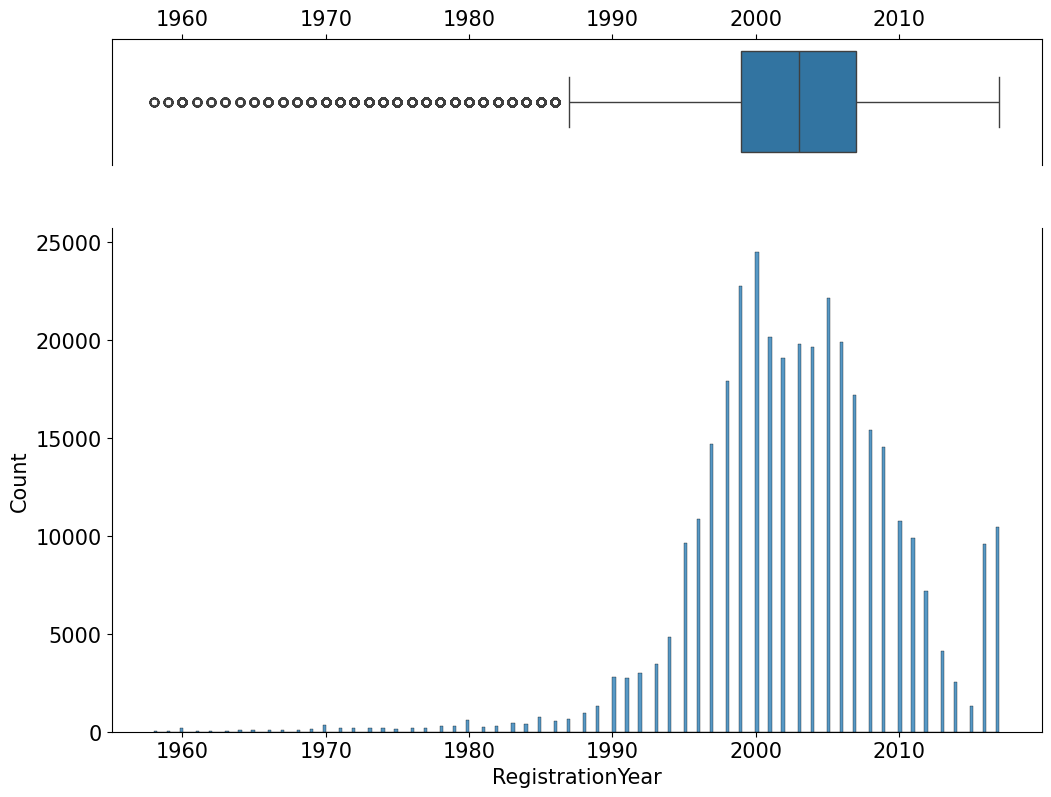

In [33]:
hist_from_series(series.loc[(series.quantile(0.001) < series) & 
                            (series < series.quantile(0.999))])

In [34]:
np.sort(series.unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Even though everything is clear with the top bar, the cutoff in the 20th century is not clear at all.

#### Engine power

In [35]:
series = data['Power']

In [36]:
series.value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: Power, Length: 712, dtype: int64

In [37]:
np.sort(series.unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Nothing is clear, but the zeros are to be replaced with something.

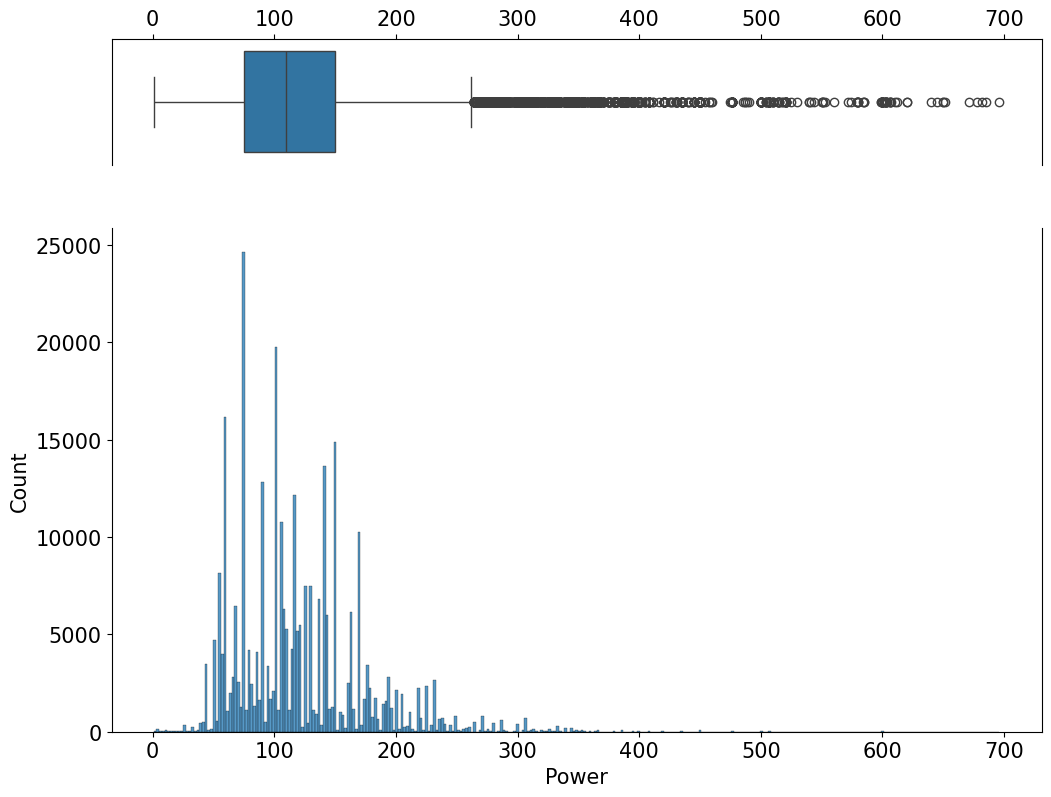

In [38]:
hist_from_series(series.loc[(series.quantile(0.001) < series) & 
                            (series < series.quantile(0.999))])

I think everything above 400 hp would have to be rounded up to the hundreds.

#### Mileage

In [39]:
series = data['Kilometer']

In [40]:
series.value_counts()

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

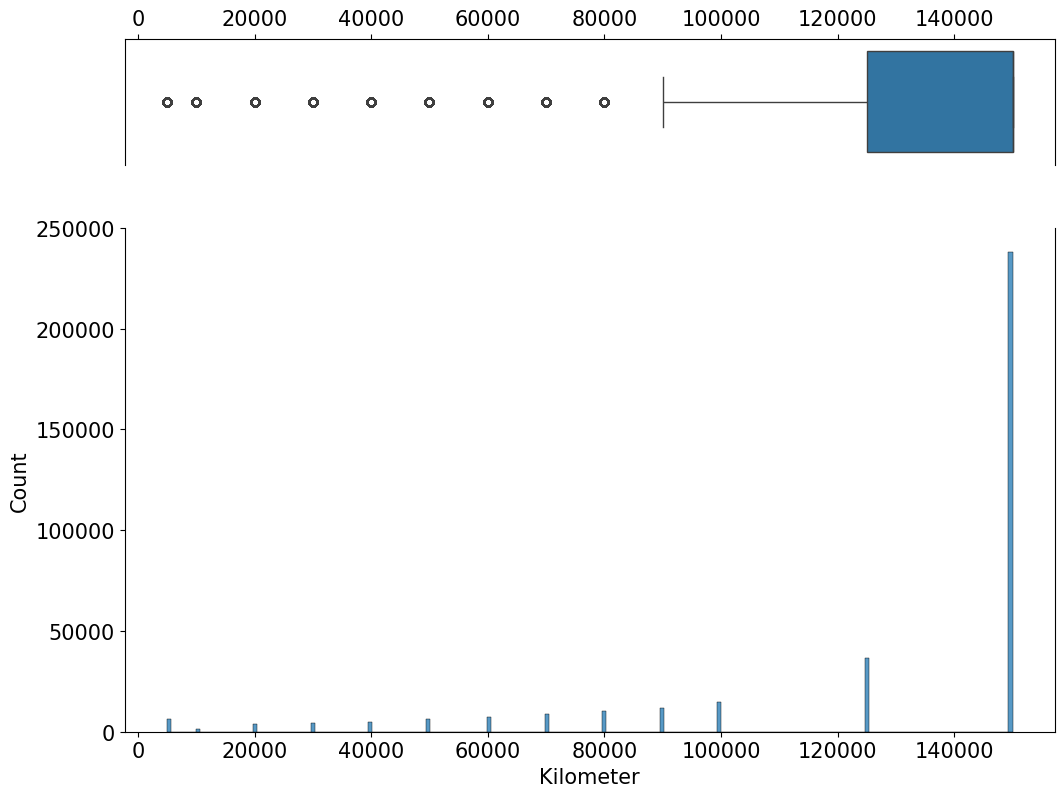

In [41]:
hist_from_series(series)

The numbers look drawn. I will have to check their correlation with the price before training the model on them.

#### Number of photos

In [42]:
series = data['NumberOfPictures']

In [43]:
series.value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

That column should be thrown away altogether. Or we shall get some real data elsewhere.

### Price dynamics

In [44]:
downloaded = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
created = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
visited = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [45]:
downloaded.dt.round('d')

0        2016-03-24
1        2016-03-24
2        2016-03-15
3        2016-03-18
4        2016-04-01
            ...    
354364   2016-03-21
354365   2016-03-15
354366   2016-03-06
354367   2016-03-20
354368   2016-03-21
Name: DateCrawled, Length: 354369, dtype: datetime64[ns]

Looks like about a month is covered.

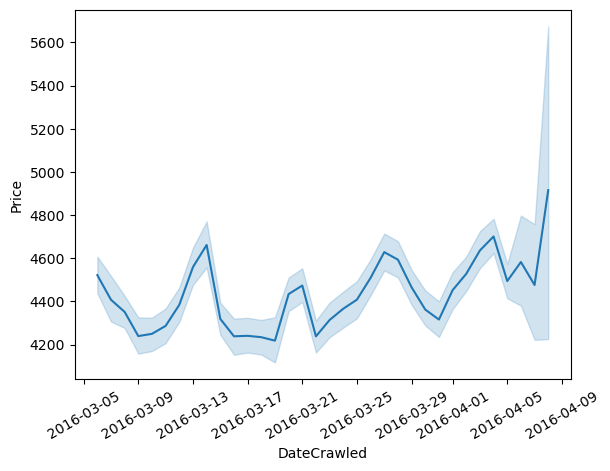

In [46]:
sb.lineplot(x=downloaded.dt.round('d'), y=data['Price'])
plt.xticks(rotation=30)
plt.show()

It's not clear to me how the day the questionnaire is downloaded can affect the price, but judging by the graph, there is some dependence.

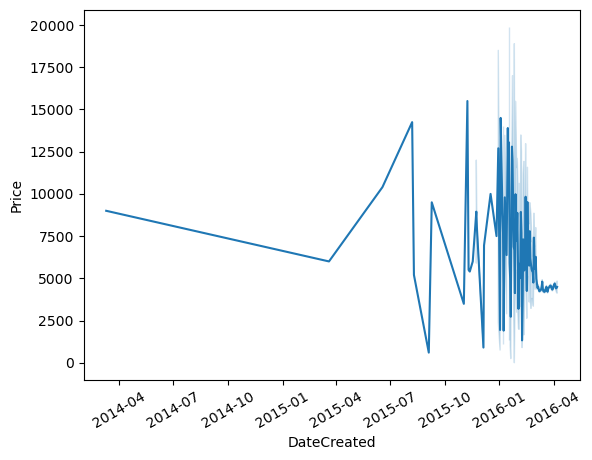

In [47]:
sb.lineplot(x=created, y=data['Price'])
plt.xticks(rotation=30)
plt.show()

The fluctuations are most likely due to the number of offers.

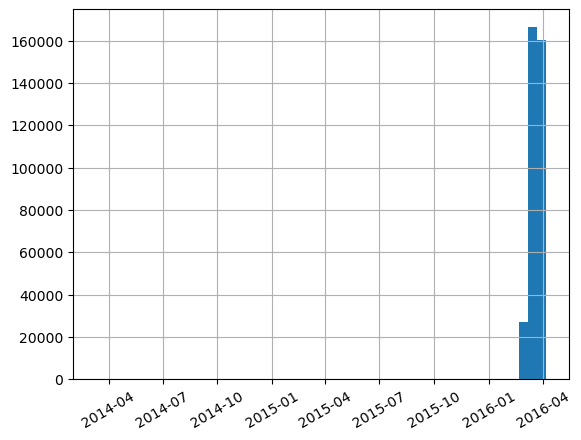

In [48]:
created.dt.round('d').hist(bins=50)
plt.xticks(rotation=30)
plt.show()

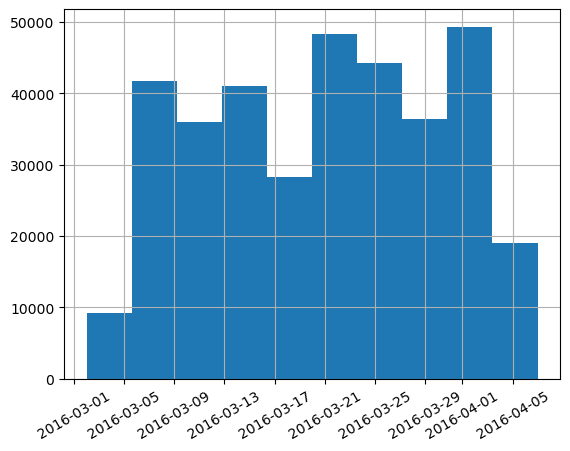

In [49]:
created.loc[created > '2016-03-01'].dt.round('d').hist()
plt.xticks(rotation=30)
plt.show()

In principle, the period up to March 2016 can be omitted. It does not reflect the market anyway.

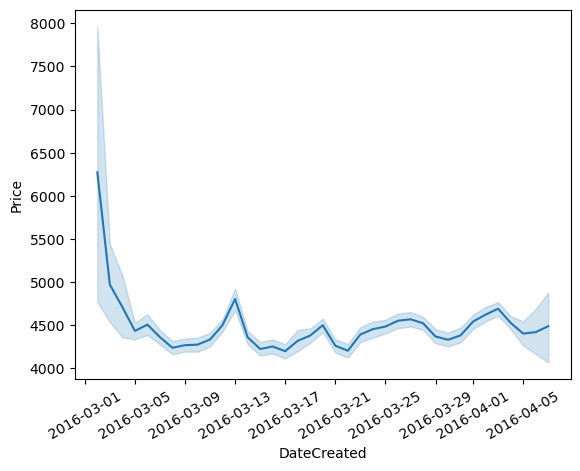

In [50]:
sb.lineplot(x=created.loc[created > '2016-03-01'], y=data['Price'])
plt.xticks(rotation=30)
plt.show()

I am not sure whether there is a linkage here.

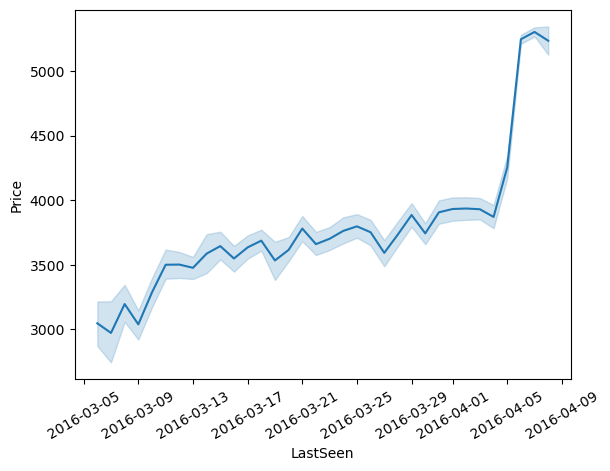

In [51]:
sb.lineplot(x=visited.dt.round('d'), y=data['Price'])
plt.xticks(rotation=30)
plt.show()

However, the day of the visit seems to have influence.

### Duplicates

In [52]:
data.duplicated().sum()

4

In [53]:
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Nothing abnormal. Throw it away and forget it.

## Data preprocessing.

Let's do it in order:
1. Renaming of the columns
2. Removing duplicates
3. Data type conversion
4. Work with missing values
5. Work with anomalous values

### Renaming

In [54]:
data.rename(columns={
    'DateCrawled': 'downloaded', 
    'Price': 'price', 
    'VehicleType': 'vehicle_type', 
    'RegistrationYear': 'year', 
    'Gearbox': 'gearbox', 
    'Power': 'power', 
    'Model': 'model', 
    'Kilometer': 'km', 
    'RegistrationMonth': 'month', 
    'FuelType': 'fuel_type', 
    'Brand': 'brand', 
    'Repaired': 'repaired', 
    'DateCreated': 'created', 
    'NumberOfPictures': 'pictures', 
    'PostalCode': 'postal_code', 
    'LastSeen': 'visited'
}, inplace=True)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   downloaded    354369 non-null  object
 1   price         354369 non-null  int64 
 2   vehicle_type  316879 non-null  object
 3   year          354369 non-null  int64 
 4   gearbox       334536 non-null  object
 5   power         354369 non-null  int64 
 6   model         334664 non-null  object
 7   km            354369 non-null  int64 
 8   month         354369 non-null  int64 
 9   fuel_type     321474 non-null  object
 10  brand         354369 non-null  object
 11  repaired      283215 non-null  object
 12  created       354369 non-null  object
 13  pictures      354369 non-null  int64 
 14  postal_code   354369 non-null  int64 
 15  visited       354369 non-null  object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Deduplication

In [56]:
data.duplicated().sum()

4

In [57]:
data = data.drop_duplicates()

No more clear duplicates.

In [58]:
len(data)

354365

In [59]:
len(data[data['downloaded'].duplicated()])

83191

In [60]:
len(data[data.duplicated()])

0

There are repeats among the dates, but there are differences for them in other columns, so they are not duplicates.

### Data types

In [61]:
data['downloaded'] = pd.to_datetime(data['downloaded'], format='%Y-%m-%d %H:%M:%S')
data['created'] = pd.to_datetime(data['created'], format='%Y-%m-%d %H:%M:%S')
data['visited'] = pd.to_datetime(data['visited'], format='%Y-%m-%d %H:%M:%S')

/tmp/ipykernel_25589/3470029938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['downloaded'] = pd.to_datetime(data['downloaded'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_25589/3470029938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['created'] = pd.to_datetime(data['created'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_25589/3470029938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

There is also an issue of the postal code. We can't use it as a quantitative variable, as the dependency is clearly non-linear. It would be nice to turn it into districts, but `pgeocode` offers several possibilities and runs very long.

### Missing values

In [62]:
data.isna().sum()

downloaded          0
price               0
vehicle_type    37490
year                0
gearbox         19833
power               0
model           19705
km                  0
month               0
fuel_type       32895
brand               0
repaired        71154
created             0
pictures            0
postal_code         0
visited             0
dtype: int64

Let's see how often the missing values match across rows.

In [63]:
with_na = data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']]

In [64]:
with_na.isna()

,vehicle_type,gearbox,model,fuel_type,repaired
0,True,False,False,False,True
1,False,False,True,False,False
2,False,False,False,False,True
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
354364,True,False,False,False,False
354365,True,True,True,True,True
354366,False,False,False,False,False
354367,False,False,False,False,False


In [65]:
with_na.isna().sum(axis=1).value_counts()

0    245810
1     64318
2     26209
3     10008
4      5783
5      2237
dtype: int64

All 5 data types play a significant role in determining the price. I think we can throw out rows where there are missing values in more than 2 columns. That's about 5% of the data.

In [66]:
data = data[~(data.isna().sum(axis=1) >= 3)]
data.isna().sum()

downloaded          0
price               0
vehicle_type    22122
year                0
gearbox          8954
power               0
model           12016
km                  0
month               0
fuel_type       18540
brand               0
repaired        55104
created             0
pictures            0
postal_code         0
visited             0
dtype: int64

- For unknown body type — replace with other
- For unknown type of gearbox — create class unknown
- For unknown model — replace with other (at least the brand will be known)
- For unknown fuel type — replace with other
- For unknown breakdown history — replace with unknown (it is not clear whether we can trust and rely on this data).

In [67]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['gearbox'] = data['gearbox'].fillna('unknown')
data['model'] = data['model'].fillna('other')
data['fuel_type'] = data['fuel_type'].fillna('other')
data['repaired'] = data['repaired'].fillna('unknown')

In [68]:
data.isna().sum()

downloaded      0
price           0
vehicle_type    0
year            0
gearbox         0
power           0
model           0
km              0
month           0
fuel_type       0
brand           0
repaired        0
created         0
pictures        0
postal_code     0
visited         0
dtype: int64

### Anomalies

So far, I've noticed the following outliers:
- About 11,000 lines with zero price. This is hardly an anomaly because the seller may have planned to bargain with the buyer. Nevertheless, these columns won't help us, they should be thrown out.
- 13 months of the year. Most likely, all the unknown information was assigned to month zero. It's a pity to throw out almost 40 000 rows. There is nothing to replace them with either. I think we can leave it that way and train the model on 13 months.
- The prevailing number of never repaired machines (with 20% of missing values, by the way). There is no way to fix this, so it would be the best not to take this column for training at all.
- Vehicle registration year before the 20th century and after 2019. The cutoff will be chosen at random.
- Zero and overestimated engine horsepower.
- Improbable mileage numbers. The lion's share of cars have 150,000 kilometers. This may have been one of the options offered to the seller, so it may be a categorical variable.
- Zero photos for all items. This column should just be thrown out, it gives no information.
- Data prior to March 5, 2016 is hardly an anomaly, but is out of trend. They should not be considered either. <a id='price'></a>

In [69]:
data = data.drop(data[data['price'] == 0].index)

In [70]:
np.sort(data['year'].unique())

array([1000, 1400, 1600, 1602, 1910, 1923, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2900,
       3700, 4000, 5000, 6000, 6500])

In [71]:
np.array(data['year'].value_counts().sort_index())

array([    1,     1,     1,     1,    16,     2,     1,     1,     7,
           2,     1,     3,     2,     3,     3,     3,     8,     7,
           2,     2,     2,     4,     1,     4,     1,     1,     2,
           1,    17,    10,     8,    12,     8,    12,    22,    11,
          20,    29,    57,    36,    37,    48,    56,    74,   102,
          91,   102,   114,   156,   154,   202,   160,   163,   135,
         151,   162,   265,   259,   287,   239,   295,   395,   375,
         518,   486,   616,   882,  1210,  1983,  2554,  2806,  3220,
        4537,  7933, 10226, 13794, 16951, 21742, 20501, 19482, 18593,
       19387, 19225, 20278, 19460, 16843, 15119, 14271, 10584,  9763,
        7073,  4051,  2472,  1091,  6313,  7189,  2780,    14,     1,
           1,     1,     5,     3,     1])

In [72]:
data = data.loc[(1950 <= data['year']) & (data['year'] <= 2016)]

In [73]:
data['power'].value_counts().sort_index()

0        25996
1           20
2            8
3            8
4           26
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 678, dtype: int64

Let's replace the zeros with the median.

In [74]:
median = data['power'].median()
data.loc[data['power'] == 0, 'power'] = median

In [75]:
np.array(data['power'].value_counts().sort_index().index).astype(int)

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,
          19,    20,    21,    22,    23,    24,    25,    26,    27,
          28,    29,    30,    31,    32,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

In [76]:
np.array(data['power'].value_counts().sort_index())

array([   20,     8,     8,    26,    93,    10,    10,     5,     4,
          10,    26,    12,     6,    18,    13,     6,     7,    47,
          10,    19,     5,     4,    37,    25,    14,   236,    37,
           5,    33,    28,     8,     3,    47,   167,    10,     6,
          43,    15,   125,   284,   419,    45,   104,   354,  2645,
          52,    29,    80,    22,  4187,    80,   288,   183,  5340,
        1804,   249,   125,  3586,   211, 14383,   957,    88,   386,
        1428,  2016,   169,   423,  2665,  3526,   915,  1379,   447,
         732,   341, 21644,   231,   846,   183,   132,  3816,   116,
        2180,   354,   911,   503,  2596,   757,  1382,    92, 11479,
         113,   427,    25,   379,  2834,   118,   506,   945,   584,
        1289, 12197,  6032,   886,   125, 35776,   387,  1238,   145,
        4564,  4396,   520,   177,   878,   852,  2829, 11273,   202,
        1153,    43,  3647,   352,  4924,    30,   206,  6405,   508,
          26,   385,

In [77]:
data['power'].value_counts()[data['power'].value_counts() == 2645].index[0]

45.0

I'll take this power as the minimum possible.

In [78]:
data = data.loc[45 <= data['power']]

In [79]:
data.loc[data['power'] >= 4500, 'power'] = data.loc[data['power'] >= 4500, 'power'] / 10

In [80]:
data.loc[data['power'] >= 450, 'power'] = data.loc[data['power'] >= 450, 'power'] / 10

In [81]:
data['power'] = data['power'].astype(int)

In [82]:
data['power'].value_counts().sort_index()

45     2731
46       53
47       63
48       83
49       23
       ... 
435      34
440       4
442       1
445      11
449       1
Name: power, Length: 355, dtype: int64

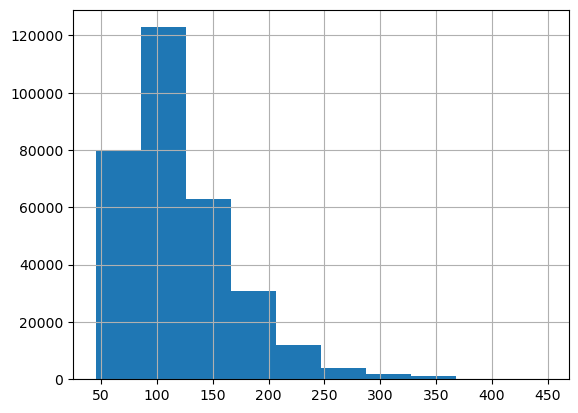

In [83]:
data['power'].hist()
plt.show()

That's more likely to be true.

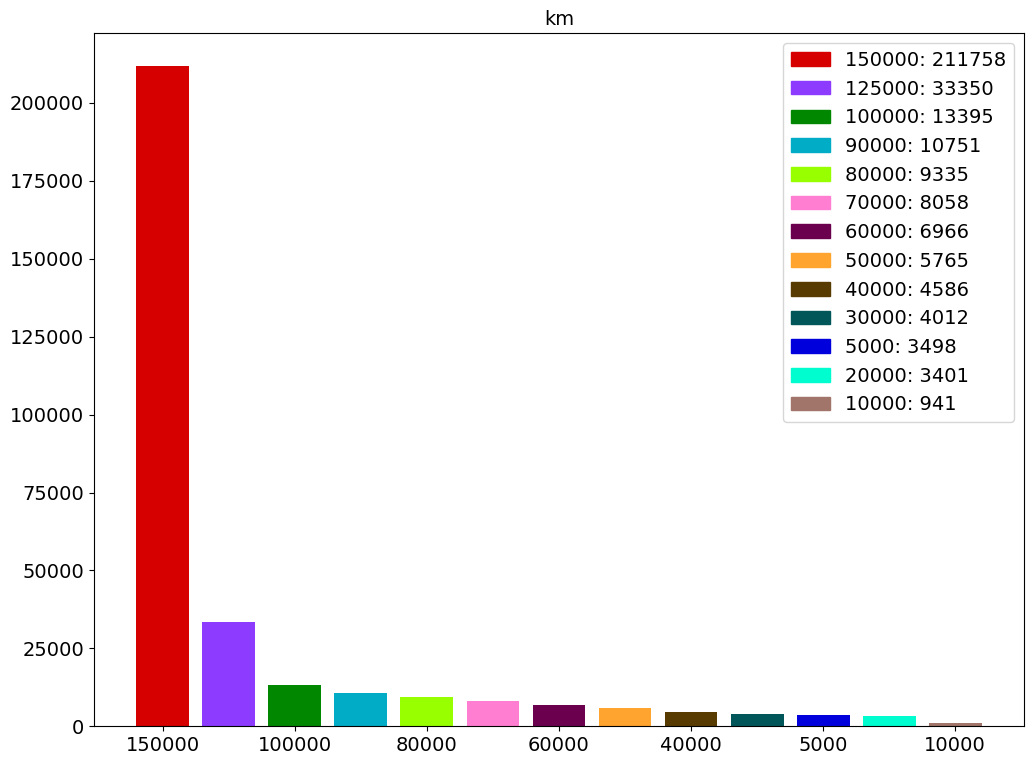

In [84]:
barplot_from_counts(data['km'].value_counts())

I'll transform it into a categorical one later.

In [85]:
data.drop('pictures', axis=1, inplace=True)

Uninformative feature removed.

In [86]:
data[data['created'] < '2016-03-05']

,downloaded,price,vehicle_type,year,gearbox,power,model,km,month,fuel_type,brand,repaired,created,postal_code,visited
67,2016-03-21 12:47:55,2100,suv,2000,manual,105,other,150000,8,petrol,honda,no,2016-02-09,85244,2016-03-31 16:46:09
352,2016-03-05 14:14:19,3900,coupe,2004,manual,192,rx_reihe,125000,7,petrol,mazda,no,2016-03-03,57520,2016-03-29 05:18:01
581,2016-03-14 17:50:40,1990,bus,2003,manual,90,other,150000,10,gasoline,ford,no,2016-03-01,82467,2016-03-21 10:45:42
768,2016-03-05 14:25:04,1300,wagon,2001,manual,75,golf,125000,4,petrol,volkswagen,no,2016-03-04,65929,2016-03-06 11:11:24
856,2016-03-06 20:48:17,11200,small,2014,manual,105,other,30000,0,petrol,skoda,no,2016-03-01,41844,2016-04-07 02:45:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353659,2016-03-05 14:08:59,1799,bus,2004,manual,75,combo,150000,5,gasoline,opel,no,2016-03-04,55481,2016-04-05 10:46:51
353856,2016-03-05 14:10:01,6300,sedan,2007,auto,116,astra,70000,9,petrol,opel,no,2016-03-03,63263,2016-03-28 22:18:58
354047,2016-03-05 14:18:10,1000,sedan,1993,manual,75,golf,150000,2,petrol,volkswagen,no,2016-03-04,35767,2016-03-06 04:45:43
354109,2016-03-05 14:23:04,17890,wagon,2011,auto,160,insignia,100000,6,gasoline,opel,no,2016-03-04,65321,2016-04-06 10:44:35


In [87]:
data = data[data['created'] >= '2016-03-05']

In [88]:
data['price'].value_counts().sort_index().head(20)

1     756
2       7
3       4
5      15
7       2
9       5
10     38
11      1
12      2
13      3
15      3
17      1
20     11
24      1
25      6
26      1
29      1
30     17
35      6
38      1
Name: price, dtype: int64

In [89]:
data = data.drop(data[data['price'] < 35].index)

## Exploratory data analysis

At this stage, we need to identify possible relationships between attributes, as well as select attributes for training. Since the target feature is price, we are looking first of all for the relationship with it.

Since some functions take a long time to work for 350,000 rows, let's study a sample of 35,000 objects.

In [90]:
sample = data.sample(frac=0.1, random_state=57)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31350 entries, 262452 to 225675
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   downloaded    31350 non-null  datetime64[ns]
 1   price         31350 non-null  int64         
 2   vehicle_type  31350 non-null  object        
 3   year          31350 non-null  int64         
 4   gearbox       31350 non-null  object        
 5   power         31350 non-null  int64         
 6   model         31350 non-null  object        
 7   km            31350 non-null  int64         
 8   month         31350 non-null  int64         
 9   fuel_type     31350 non-null  object        
 10  brand         31350 non-null  object        
 11  repaired      31350 non-null  object        
 12  created       31350 non-null  datetime64[ns]
 13  postal_code   31350 non-null  int64         
 14  visited       31350 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(6)

### Period

Let's look at the dates the proposals were created.

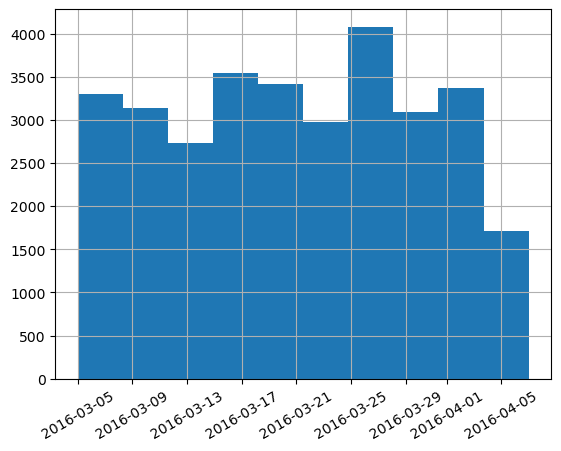

In [91]:
sample['created'].dt.round('d').hist()
plt.xticks(rotation=30)
plt.show()

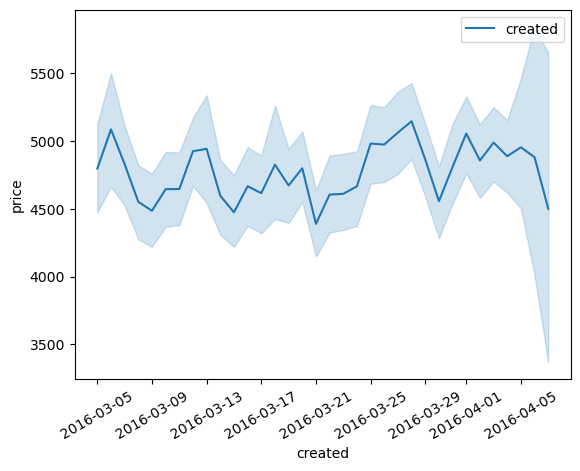

In [92]:
sb.lineplot(x=sample['created'].dt.round('d'), y=sample['price'], label='created')
plt.xticks(rotation=30)
plt.legend()
plt.show()

The price didn't change too much during that time. I think this column can be dropped.

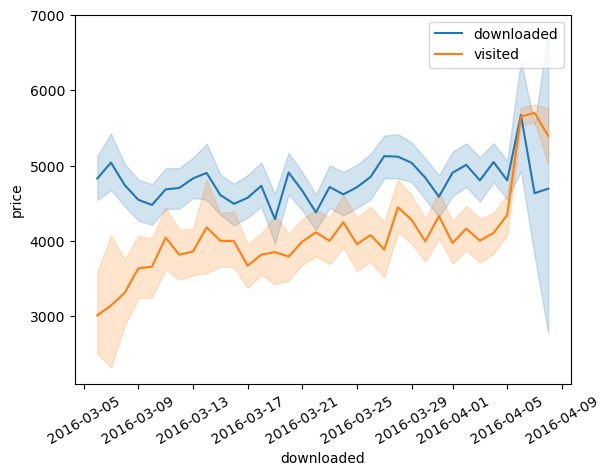

In [93]:
sb.lineplot(x=sample['downloaded'].dt.round('d'), y=sample['price'], label='downloaded')
sb.lineplot(x=sample['visited'].dt.round('d'), y=sample['price'], label='visited')
plt.xticks(rotation=30)
plt.legend()
plt.show()

The time of download is unlikely to affect the price, but the date of last visit may well. 

Let's convert it to seconds on a small sample and use it as a quantitative variable.

In [94]:
%%time
subsample = data.sample(frac=0.01, random_state=57)
seconds = subsample['visited'].apply(lambda x: 
                                     round((max(subsample['visited']) - x).total_seconds()))

CPU times: user 9.26 s, sys: 5.46 ms, total: 9.27 s
Wall time: 9.25 s


In [95]:
seconds.corr(subsample['price'])

-0.12227655531259655

There is some small correlation.

### Postal code

The situation is similar with the postal code. Let's try to evaluate how meaningful it is to transform it into locations.

In [96]:
eu_countries = ['AD', 'AT', 'AX', 'BE', 'BG', 'CH', 'CZ', 
                'DE', 'DK', 'ES', 'FI', 'FO', 'FR', 'GB', 
                'GG', 'GL', 'HR', 'HU', 'IE', 'IM', 'IT', 
                'JE', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 
                'MK', 'MT', 'NL', 'NO', 'PL', 'PM', 'PT', 
                'RO', 'SE', 'SI', 'SJ', 'SK', 'SM', 'VA']

Of the 324 cases, 246 are in Germany, another 52 offer to choose between Germany and some other country. 3 offers were not found among the European countries. 

Within Germany, the classification is already more meaningful. However, it is still unclear which country to choose in some cases.

In general, let's not use this information when teaching. All the more it is calculated very long.

### Vehicle body type

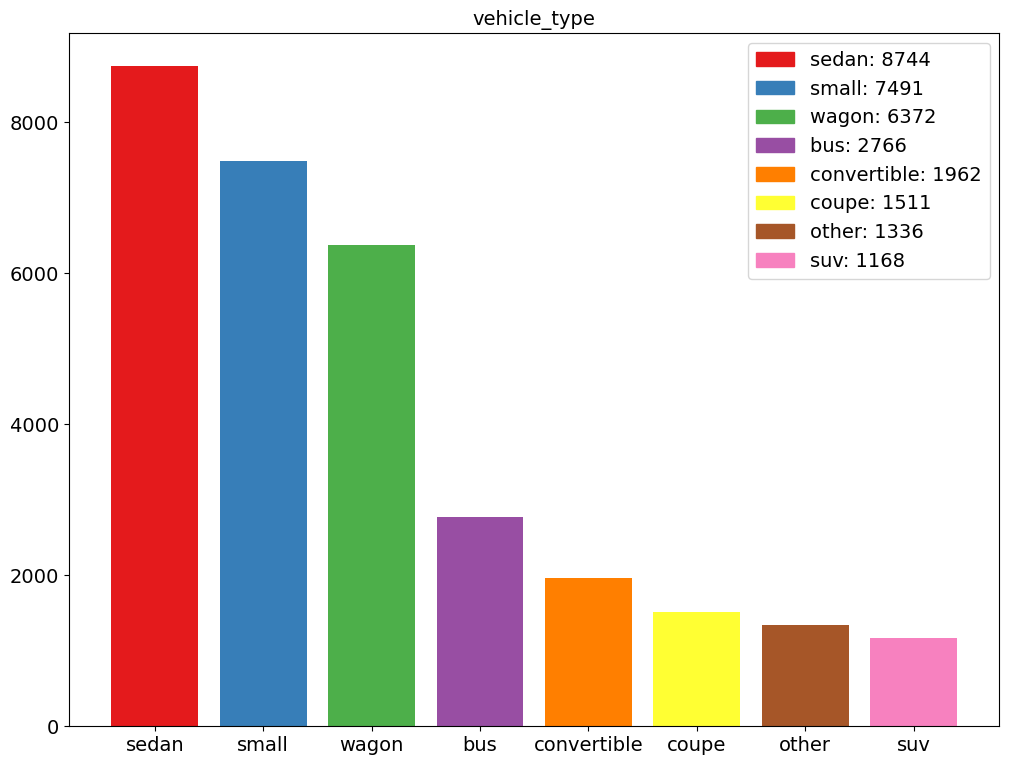

In [97]:
barplot_from_counts(sample['vehicle_type'].value_counts())

In [98]:
vehicle_stat = (sample
                .groupby('vehicle_type')['price']
                .agg(['count', 'mean', 'median'])
                .sort_values(by='count', ascending=False))
vehicle_stat

,count,mean,median
vehicle_type,,,
sedan,8744,4897.866651,3100
small,7491,2770.428247,1600
wagon,6372,5154.241996,3500
bus,2766,5489.066522,4200
convertible,1962,6910.125382,5500
coupe,1511,6261.535407,4250
other,1336,2909.621257,1450
suv,1168,9375.623288,8900


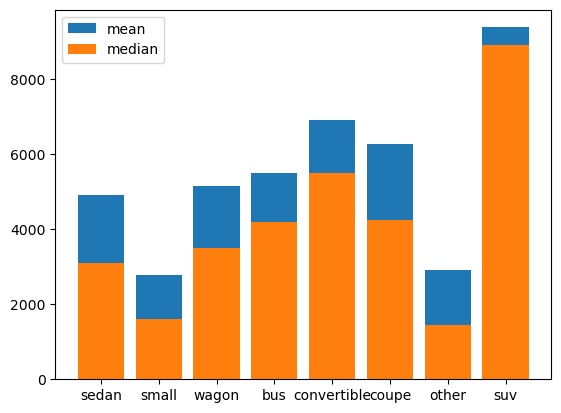

In [99]:
plt.bar(x=vehicle_stat.index, height=vehicle_stat['mean'], label='mean')
plt.bar(x=vehicle_stat.index, height=vehicle_stat['median'], label='median')
plt.legend()
plt.show()

In general, we can say that the rarer a car is, the more sellers ask for it.

### Registration year

In [100]:
data['year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009,
       2002, 1997, 1990, 1981, 2003, 2016, 1994, 1991, 1984, 2006, 1999,
       2012, 2010, 1992, 2013, 2000, 1996, 1989, 2015, 1985, 1976, 1983,
       1969, 1971, 1987, 1973, 1986, 1982, 1988, 1980, 1965, 1970, 1974,
       1979, 1978, 1972, 1968, 1977, 1961, 1966, 1975, 1963, 1958, 1967,
       1964, 1960, 1951, 1959, 1953, 1956, 1962, 1950, 1955, 1952, 1957,
       1954])

In [101]:
year_stat = (sample
             .groupby('year')['price']
             .agg(['count', 'mean', 'median'])
             .sort_index())
year_stat

,count,mean,median
year,,,
1950,2,19250.000000,19250.0
1952,1,3800.000000,3800.0
1953,2,1874.500000,1874.5
1955,4,15337.500000,15850.0
1956,1,2990.000000,2990.0
...,...,...,...
2012,736,12225.645380,12050.0
2013,398,12892.635678,12900.0
2014,253,13220.869565,13700.0


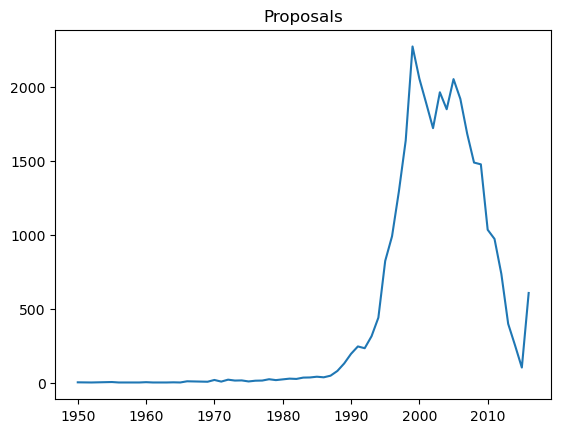

In [102]:
plt.plot(year_stat.index, year_stat['count'])
plt.title('Proposals')
plt.show()

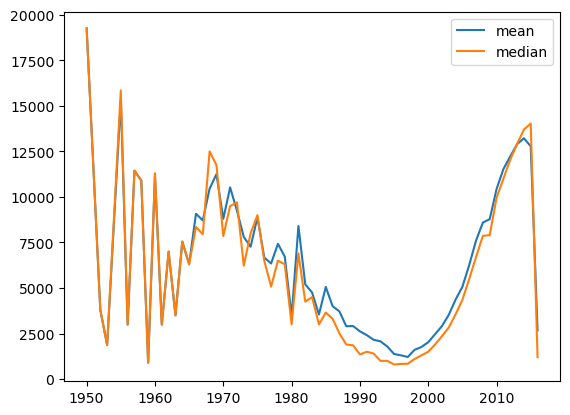

In [103]:
plt.plot(year_stat.index, year_stat['mean'], label='mean')
plt.plot(year_stat.index, year_stat['median'], label='median')
plt.legend()
plt.show()

For the main dataset, there is a clear upward trend in price with novelty.

### Gearbox

In [104]:
gearbox_stat = (sample
             .groupby('gearbox')['price']
             .agg(['count', 'mean', 'median'])
             .sort_index())
gearbox_stat

,count,mean,median
gearbox,,,
auto,6190,7245.962682,5950
manual,24345,4196.109427,2650
unknown,815,3013.309202,2250


Apparently, the price depends on the gearbox automation.

### Engine power

In [105]:
power_stat = (sample
             .groupby('power')['price']
             .agg(['count', 'mean', 'median'])
             .sort_index())
power_stat

,count,mean,median
power,,,
45,268,1666.029851,699.5
46,10,4305.000000,3175.0
47,5,7599.800000,2500.0
48,12,4095.583333,2350.0
49,3,553.000000,499.0
...,...,...,...
420,2,8750.000000,8750.0
431,1,19990.000000,19990.0
435,5,16880.000000,17200.0


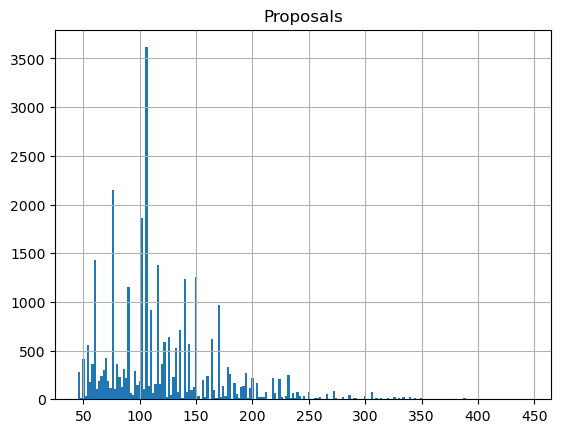

In [106]:
sample['power'].hist(bins=200)
plt.title('Proposals')
plt.show()

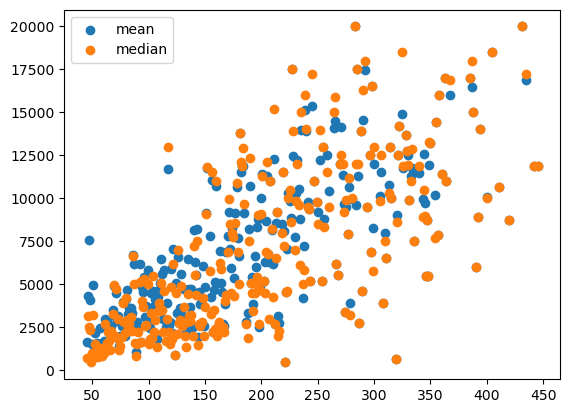

In [107]:
plt.scatter(power_stat.index, power_stat['mean'], label='mean')
plt.scatter(power_stat.index, power_stat['median'], label='median')
plt.legend()
plt.show()

In [108]:
sample['price'].corr(sample['power'])

0.5059295126901395

Correlation, of course, does not imply causation. But there is still a reason to believe that price depends on power.

### Car model

In [109]:
len(sample['model'].unique())

245

Let's check how unambiguously the models match the brands.

In [110]:
models_by_brand = sample.groupby('brand')['model'].unique()
models_by_brand

brand
alfa_romeo                      [156, 145, 147, other, spider, 159]
audi              [a4, q7, 90, a6, a3, a5, a8, 80, other, a1, 10...
bmw               [3er, 5er, other, x_reihe, 1er, z_reihe, 7er, ...
chevrolet                      [matiz, aveo, captiva, other, spark]
chrysler          [other, crossfire, voyager, ptcruiser, 300c, g...
citroen                       [c3, c5, other, c4, c2, c1, berlingo]
dacia                        [sandero, logan, duster, lodgy, other]
daewoo                         [matiz, nubira, kalos, other, lanos]
daihatsu          [sirion, terios, cuore, other, move, materia, ...
fiat              [punto, other, 500, bravo, doblo, stilo, seice...
ford              [ka, escort, focus, fiesta, other, mondeo, kug...
honda                        [cr_reihe, other, accord, civic, jazz]
hyundai                       [other, i_reihe, santa, tucson, getz]
jaguar                                      [other, x_type, s_type]
jeep                             [grand, o

In [111]:
sets = []
for brand_from in models_by_brand.index:
    for brand_to in models_by_brand.index:
        if brand_from != brand_to:
            sets.append(set(models_by_brand[brand_from]) & set(models_by_brand[brand_to]))
# sets

In [112]:
for i in sets:
    if i != {'other'}:
        print(i)

{'matiz', 'other'}
{'grand', 'other'}
{'grand', 'other'}
{'matiz', 'other'}
{'grand', 'other'}
{'grand', 'other'}
{'freelander', 'discovery', 'other'}
{'1_reihe', '3_reihe', 'other', '5_reihe'}
{'1_reihe', '3_reihe', 'other', '5_reihe'}
{'freelander', 'discovery', 'other'}
{'grand', 'other'}
{'grand', 'other'}


By and large, the models don't overlap. The question is whether to use them in training or make do with the brand. I think it is better not to take it because it will encourage overtraining.

### Mileage

In [113]:
km_stat = (sample.groupby('km')['price'].agg(['count', 'mean', 'median']).sort_index())
km_stat

,count,mean,median
km,,,
5000,331,4160.265861,1700.0
10000,80,11537.625000,12110.5
20000,367,9311.476839,9000.0
30000,418,10108.069378,9900.0
40000,451,9965.481153,9300.0
50000,559,9393.166369,8500.0
60000,754,9143.026525,8100.0
70000,752,8275.559840,7145.0
80000,940,7433.852128,6400.0


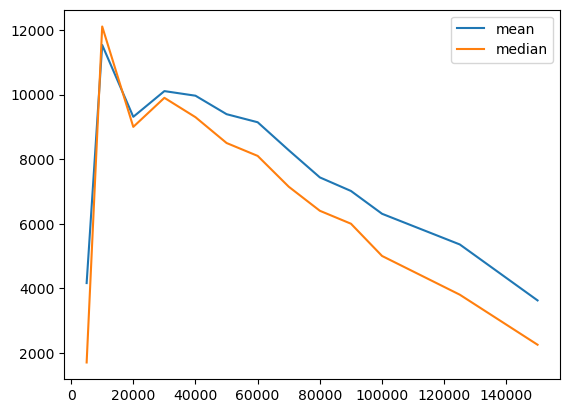

In [114]:
plt.plot(km_stat.index, km_stat['mean'], label='mean')
plt.plot(km_stat.index, km_stat['median'], label='median')
plt.legend()
plt.show()

It turns out that almost unused cars are valued low. This may be due to the year of manufacture.

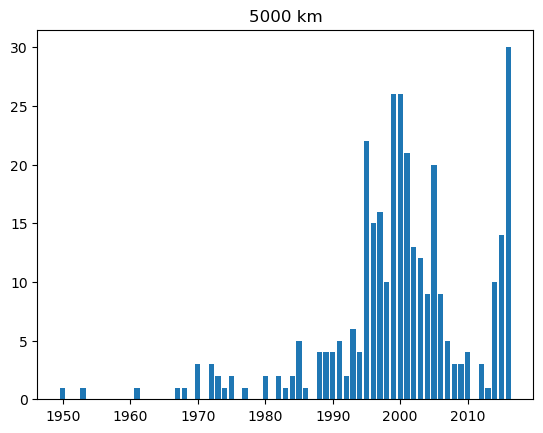

In [115]:
km_by_year = sample[sample['km'] == 5000]['year'].value_counts().sort_index()
plt.bar(x=km_by_year.index, height=km_by_year)
plt.title('5000 km')
plt.show()

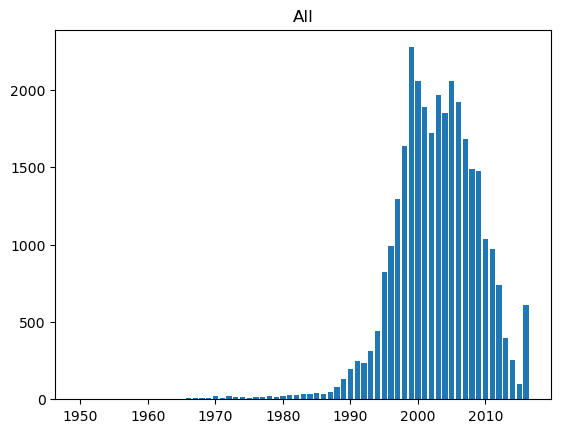

In [116]:
km_by_year_total = sample['year'].value_counts().sort_index()
plt.bar(x=km_by_year_total.index, height=km_by_year_total)
plt.title('All')
plt.show()

No, it doesn't look like it.

### Month

In [117]:
sample.groupby('month')['price']

In [118]:
month_stat = (sample
             .groupby('month')['price']
             .agg(['count', 'mean', 'median'])
             .sort_index())
month_stat

,count,mean,median
month,,,
0,2153,2375.229447,1300
1,2048,4733.095703,2999
2,1902,4789.637224,3000
3,3224,4755.536290,2999
4,2729,5059.130817,3400
5,2690,4927.915613,3350
6,2827,4869.239830,3100
7,2506,5104.338787,3500
8,2123,4709.706076,2990


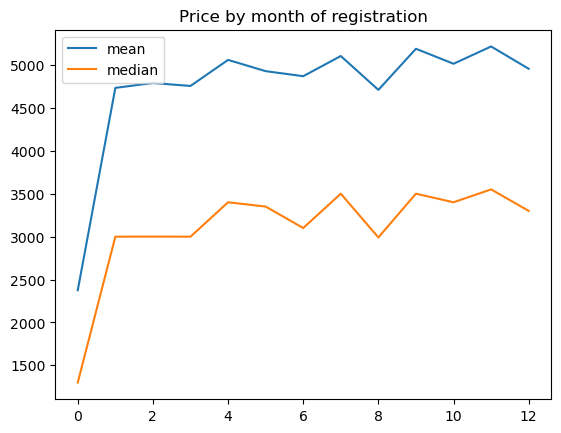

In [119]:
plt.plot(month_stat.index, month_stat['mean'], label='mean')
plt.plot(month_stat.index, month_stat['median'], label='median')
plt.title('Price by month of registration')
plt.legend()
plt.show()

Seems like this column does not affect the price.

In [120]:
sample['price'].corr(sample['month'])

0.08204929198706952

Apparently not. Let's not train on it.

### Fuel type

In [121]:
fuel_stat = (sample
             .groupby('fuel_type')['price']
             .agg(['count', 'mean', 'median'])
             .sort_index())
fuel_stat

,count,mean,median
fuel_type,,,
cng,57,4819.192982,4500
electric,4,10912.500000,10375
gasoline,9350,6892.283850,5699
hybrid,23,9472.130435,10900
lpg,454,4478.830396,3333
other,1481,2882.409183,1500
petrol,19981,3912.784445,2250


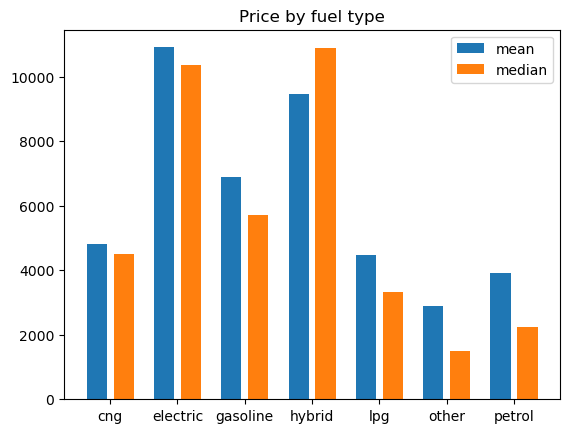

In [122]:
x_axis = np.arange(len(fuel_stat))
plt.bar(x=x_axis - 0.2, width=0.3, height=fuel_stat['mean'], label='mean')
plt.bar(x=x_axis + 0.2, width=0.3, height=fuel_stat['median'], label='median')
plt.xticks(x_axis, fuel_stat.index)
plt.title('Price by fuel type')
plt.legend()
plt.show()

There is little data for electric and hybrid-fueled vehicles, but there appears to be a correlation.

### Brand

In [123]:
brand_stat = (sample
             .groupby('brand')['price']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='mean'))
brand_stat

,count,mean,median
brand,,,
daewoo,45,977.800000,900.0
rover,36,1480.666667,950.0
daihatsu,61,2081.918033,1300.0
trabant,9,2097.000000,2000.0
renault,1576,2401.462563,1350.0
lancia,37,2486.270270,1300.0
fiat,805,2903.925466,1750.0
opel,3534,3017.632428,1700.0
mitsubishi,264,3332.837121,1600.0


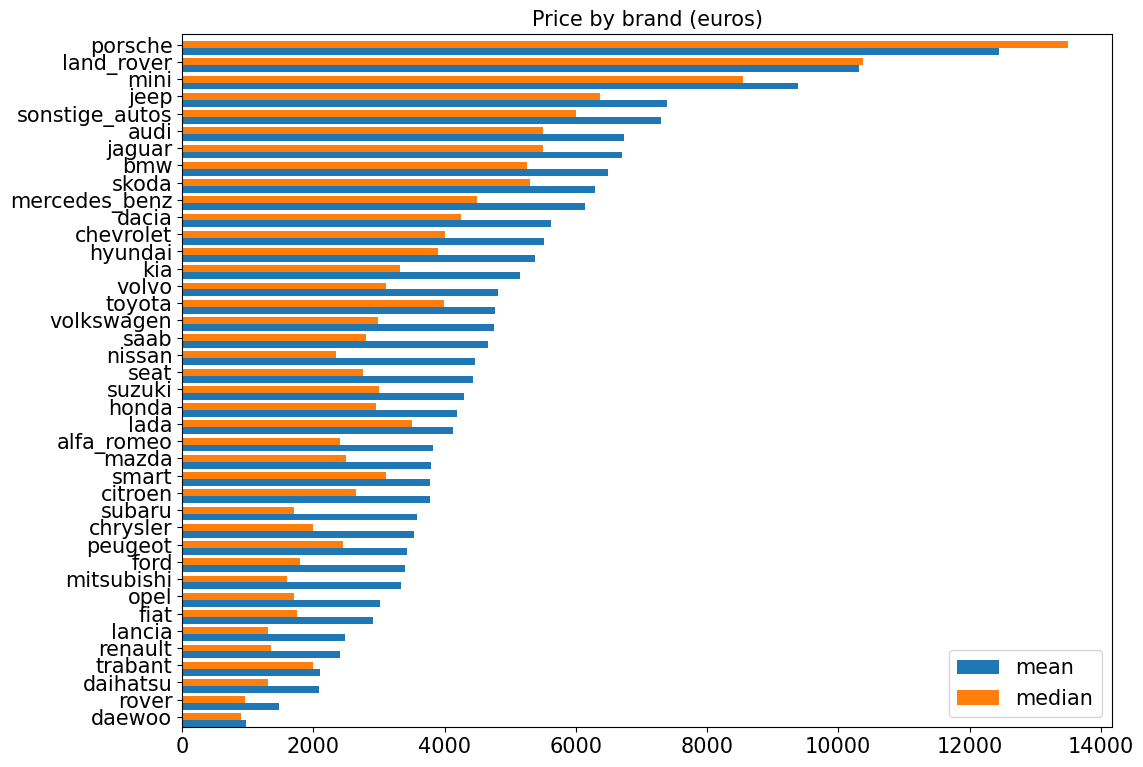

In [124]:
x_axis = np.arange(len(brand_stat))
fig, ax = plt.subplots(figsize=(12, 9))
ax.barh(x_axis, brand_stat['mean'], 0.4, label='mean')
ax.barh(x_axis + 0.4, brand_stat['median'], 0.4, label='median')

ax.set(yticks=x_axis + 0.4, yticklabels=brand_stat.index, ylim=[2*0.4 - 1, len(brand_stat)])
ax.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Price by brand (euros)', fontsize=15)
plt.show()

Not surprisingly, there's a dependency here.

### Breakdown history

In [125]:
repair_stat = (sample
             .groupby('repaired')['price']
             .agg(['count', 'mean', 'median', 'std'])
             .sort_values(by='mean'))
repair_stat

,count,mean,median,std
repaired,,,,
yes,3190,2158.423511,1000,2909.581567
unknown,4807,3133.212191,1800,3558.690219
no,23353,5460.365606,3850,4753.213788


I wonder if the price depends on the year the application was created.

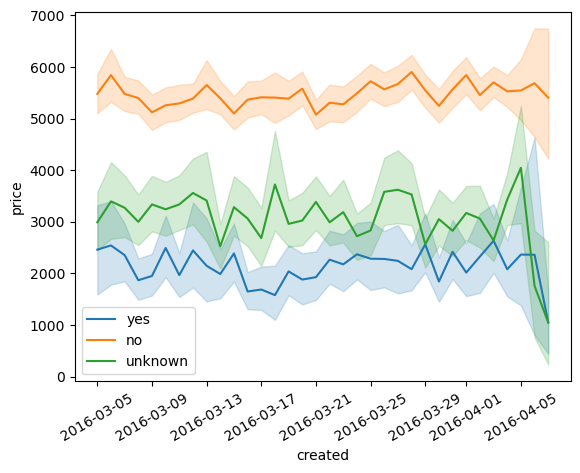

In [126]:
sb.lineplot(x=sample[sample['repaired'] == 'yes']['created'].round('d'), 
            y=sample[sample['repaired'] == 'yes']['price'], label='yes')
sb.lineplot(x=sample[sample['repaired'] == 'no']['created'].round('d'), 
            y=sample[sample['repaired'] == 'no']['price'], label='no')
sb.lineplot(x=sample[sample['repaired'] == 'unknown']['created'].round('d'), 
            y=sample[sample['repaired'] == 'unknown']['price'], label='unknown')
plt.xticks(rotation=30)
plt.legend()
plt.show()

If we put a standard deviation instead of a confidence interval, it's not so pretty.

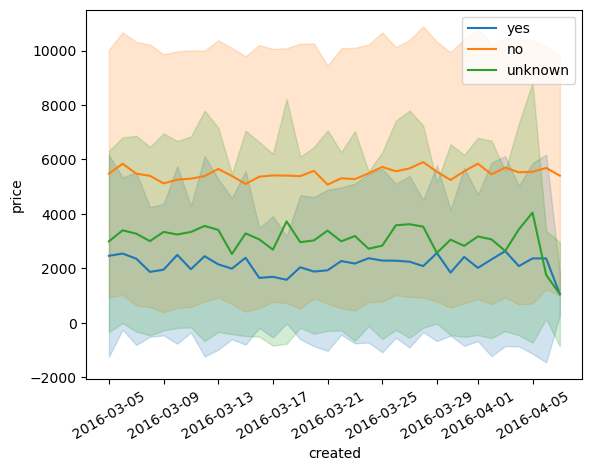

In [127]:
sb.lineplot(x=sample[sample['repaired'] == 'yes']['created'].round('d'), 
            y=sample[sample['repaired'] == 'yes']['price'], label='yes', errorbar='sd')
sb.lineplot(x=sample[sample['repaired'] == 'no']['created'].round('d'), 
            y=sample[sample['repaired'] == 'no']['price'], label='no', errorbar='sd')
sb.lineplot(x=sample[sample['repaired'] == 'unknown']['created'].round('d'), 
            y=sample[sample['repaired'] == 'unknown']['price'], label='unknown', errorbar='sd')
plt.xticks(rotation=30)
plt.legend()
plt.show()

That's essentially how it should be though. Unbroken cars of different price ranges can be sold on the same day, so nothing strange here. The sign is significant, even if it doesn't reflect reality.

### Relationship of attributes

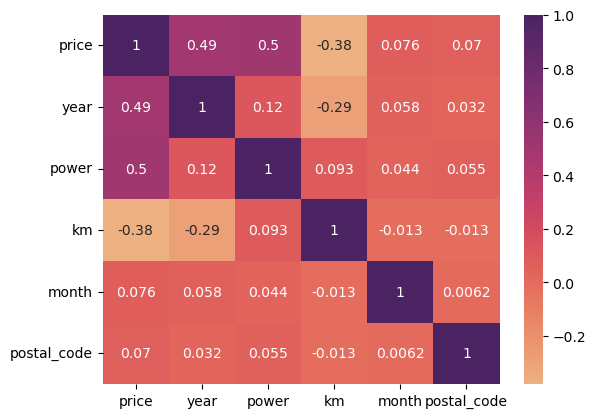

In [128]:
corr_matrix = data.corr()
sb.heatmap(corr_matrix, cmap='flare', annot=True)
plt.yticks(rotation=0)
plt.show()

The price is dependent on a number of attributes, which cannot but rejoice. As for the attributes for training, there is no multicollinearity between them. Except for a little bit between year and mileage.

## Samples

Since ~350,000 objects can take a long time to process, let's take 25% of this data.

For them we also need to:
1. select the features for the training
2. conduct OHE for categorical variables
3. conduct scaling for numerical variables

In [129]:
sample = data.sample(frac=0.25, random_state=57)
sample.dtypes

downloaded      datetime64[ns]
price                    int64
vehicle_type            object
year                     int64
gearbox                 object
power                    int64
model                   object
km                       int64
month                    int64
fuel_type               object
brand                   object
repaired                object
created         datetime64[ns]
postal_code              int64
visited         datetime64[ns]
dtype: object

### Features for training

In [130]:
features = sample.drop(['downloaded', 
                        'price', 
                        'model', 
                        'month', 
                        'created', 
                        'postal_code'], axis=1)
target = sample['price']
print(features.shape)
print(target.shape)

(78374, 9)
(78374,)


In [131]:
features

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired,visited
262452,wagon,1999,manual,125,150000,petrol,volkswagen,unknown,2016-04-05 12:17:29
323263,wagon,1996,manual,116,150000,petrol,bmw,no,2016-04-06 15:18:01
139907,small,2009,manual,69,60000,petrol,ford,unknown,2016-04-06 00:44:44
112881,sedan,2002,manual,163,150000,petrol,mercedes_benz,no,2016-04-01 16:55:42
72971,wagon,2006,manual,116,150000,gasoline,audi,no,2016-03-07 15:45:13
...,...,...,...,...,...,...,...,...,...
172674,wagon,2005,manual,116,150000,gasoline,bmw,no,2016-03-13 01:17:49
162873,convertible,2005,manual,101,150000,petrol,opel,no,2016-03-12 21:46:56
37884,sedan,2007,manual,224,150000,gasoline,mercedes_benz,no,2016-04-05 16:46:24
178618,wagon,2002,auto,143,150000,gasoline,mercedes_benz,unknown,2016-03-27 18:44:43


In [132]:
features.drop('visited', axis=1, inplace=True)

In [133]:
features

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
262452,wagon,1999,manual,125,150000,petrol,volkswagen,unknown
323263,wagon,1996,manual,116,150000,petrol,bmw,no
139907,small,2009,manual,69,60000,petrol,ford,unknown
112881,sedan,2002,manual,163,150000,petrol,mercedes_benz,no
72971,wagon,2006,manual,116,150000,gasoline,audi,no
...,...,...,...,...,...,...,...,...
172674,wagon,2005,manual,116,150000,gasoline,bmw,no
162873,convertible,2005,manual,101,150000,petrol,opel,no
37884,sedan,2007,manual,224,150000,gasoline,mercedes_benz,no
178618,wagon,2002,auto,143,150000,gasoline,mercedes_benz,unknown


This is the form in which the data will come into work.

### Splitting

Let's divide the samples into training, validation and test samples. This is necessary even for models with cross-validation, because we will need to conduct a mini-test after parameter selection.

In [134]:
features_train, features_valid, features_test = np.split(features.sample(
    frac=1, random_state=57),[int(0.6*len(features)), int(0.8*len(features))])
target_train, target_valid, target_test = np.split(target.sample(
    frac=1, random_state=57),[int(0.6*len(target)), int(0.8*len(target))])
# .sample(frac=1) to mix the dataframe, then the indexes by which we split the data

In [135]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(47024, 8)
(15675, 8)
(15675, 8)
(47024,)
(15675,)
(15675,)


In [136]:
features_train

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,wagon,2005,auto,140,150000,gasoline,audi,no
34735,sedan,2003,manual,150,90000,gasoline,mercedes_benz,no
313161,other,2000,manual,105,100000,petrol,fiat,unknown
263346,bus,2002,manual,147,150000,petrol,opel,no
126860,sedan,1998,manual,101,150000,other,volkswagen,no
...,...,...,...,...,...,...,...,...
69954,sedan,1991,manual,105,150000,other,opel,no
278609,coupe,1999,manual,150,150000,petrol,bmw,no
3433,sedan,2004,manual,105,125000,petrol,seat,no
43224,sedan,1994,manual,136,125000,petrol,mercedes_benz,no


In [137]:
target_train

159639    6600
34735     8900
313161    1500
263346    2100
126860    1500
          ... 
69954      800
278609    3000
3433      3750
43224     1111
86464     5300
Name: price, Length: 47024, dtype: int64

### Scaling

We will scale the motor power values, as well as time in seconds, if used.

In [138]:
scaler = StandardScaler()

try:
    scaler.fit(features_train[['power', 'seconds']])
    features_train[['power', 'seconds']] = scaler.transform(
        features_train[['power', 'seconds']])
    features_valid[['power', 'seconds']] = scaler.transform(
        features_valid[['power', 'seconds']])
    features_test[['power', 'seconds']] = scaler.transform(
        features_test[['power', 'seconds']])
except:
    scaler.fit(features_train[['power']])
    features_train['power'] = scaler.transform(features_train[['power']])
    features_valid['power'] = scaler.transform(features_valid[['power']])
    features_test['power'] = scaler.transform(features_test[['power']])

In [139]:
features_train

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,wagon,2005,auto,0.406812,150000,gasoline,audi,no
34735,sedan,2003,manual,0.605208,90000,gasoline,mercedes_benz,no
313161,other,2000,manual,-0.287575,100000,petrol,fiat,unknown
263346,bus,2002,manual,0.545689,150000,petrol,opel,no
126860,sedan,1998,manual,-0.366933,150000,other,volkswagen,no
...,...,...,...,...,...,...,...,...
69954,sedan,1991,manual,-0.287575,150000,other,opel,no
278609,coupe,1999,manual,0.605208,150000,petrol,bmw,no
3433,sedan,2004,manual,-0.287575,125000,petrol,seat,no
43224,sedan,1994,manual,0.327453,125000,petrol,mercedes_benz,no


### Samples with one-hot encoding

In [140]:
features_train[['year', 'km']] = features_train[['year', 'km']].astype(str)
features_valid[['year', 'km']] = features_valid[['year', 'km']].astype(str)
features_test[['year', 'km']] = features_test[['year', 'km']].astype(str)

In [141]:
features_valid

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
304403,other,2012,manual,-0.188377,40000,petrol,kia,unknown
104873,other,2016,manual,-0.287575,150000,petrol,opel,unknown
270484,small,2005,manual,-1.180358,125000,petrol,ford,no
198191,small,1998,manual,-0.664528,150000,petrol,toyota,no
32356,small,2012,manual,0.049699,20000,petrol,mini,no
...,...,...,...,...,...,...,...,...
16674,sedan,1992,manual,1.081359,150000,petrol,audi,no
110158,small,2002,manual,-0.882763,80000,petrol,opel,no
227995,wagon,2012,manual,-0.545490,60000,gasoline,peugeot,no
130757,wagon,2012,auto,0.406812,150000,gasoline,volkswagen,no


In [142]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True, 
                                    columns=features_train.columns.drop('power'))
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True, 
                                    columns=features_valid.columns.drop('power'))
features_test_ohe = pd.get_dummies(features_test, drop_first=True, 
                                    columns=features_test.columns.drop('power'))

In [143]:
features_train_ohe

,power,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,year_1953,year_1955,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
159639,0.406812,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
34735,0.605208,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313161,-0.287575,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
263346,0.545689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126860,-0.366933,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69954,-0.287575,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278609,0.605208,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3433,-0.287575,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43224,0.327453,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
features_valid_ohe

,power,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,year_1955,year_1958,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
304403,-0.188377,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
104873,-0.287575,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
270484,-1.180358,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198191,-0.664528,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
32356,0.049699,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16674,1.081359,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110158,-0.882763,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227995,-0.545490,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
130757,0.406812,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [145]:
common_columns = (set(features_train_ohe.columns) & 
                  set(features_valid_ohe.columns) & 
                  set(features_test_ohe.columns))
len(common_columns)

126

The number of columns is different because not all unique values may be in the test sample, for example.

In [146]:
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [147]:
features_train_ohe.shape

(47024, 126)

### Samples with ordinal encoding

In [148]:
features_train

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,wagon,2005,auto,0.406812,150000,gasoline,audi,no
34735,sedan,2003,manual,0.605208,90000,gasoline,mercedes_benz,no
313161,other,2000,manual,-0.287575,100000,petrol,fiat,unknown
263346,bus,2002,manual,0.545689,150000,petrol,opel,no
126860,sedan,1998,manual,-0.366933,150000,other,volkswagen,no
...,...,...,...,...,...,...,...,...
69954,sedan,1991,manual,-0.287575,150000,other,opel,no
278609,coupe,1999,manual,0.605208,150000,petrol,bmw,no
3433,sedan,2004,manual,-0.287575,125000,petrol,seat,no
43224,sedan,1994,manual,0.327453,125000,petrol,mercedes_benz,no


In [149]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
cat_features = list(features.columns.drop('power'))
encoder.fit(features_train[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)

In [150]:
features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_features] = encoder.transform(features_train_ord[cat_features])
features_valid_ord[cat_features] = encoder.transform(features_valid_ord[cat_features])
features_test_ord[cat_features] = encoder.transform(features_test_ord[cat_features])

In [151]:
features_train_ord

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,7.0,52.0,0.0,0.406812,3.0,2.0,1.0,0.0
34735,4.0,50.0,1.0,0.605208,12.0,2.0,20.0,0.0
313161,3.0,47.0,1.0,-0.287575,1.0,6.0,9.0,1.0
263346,0.0,49.0,1.0,0.545689,3.0,6.0,24.0,0.0
126860,4.0,45.0,1.0,-0.366933,3.0,5.0,38.0,0.0
...,...,...,...,...,...,...,...,...
69954,4.0,38.0,1.0,-0.287575,3.0,5.0,24.0,0.0
278609,2.0,46.0,1.0,0.605208,3.0,6.0,2.0,0.0
3433,4.0,51.0,1.0,-0.287575,2.0,6.0,30.0,0.0
43224,4.0,41.0,1.0,0.327453,2.0,6.0,20.0,0.0


## Training

Let's try linear regression, random forest, LightGBM, CatBoost and XGBoost.

### Linear regression

In [152]:
%%time
model = LinearRegression()
model.fit(features_train_ohe, target_train)

CPU times: user 705 ms, sys: 172 ms, total: 877 ms
Wall time: 293 ms


LinearRegression()

In [153]:
%%time
predictions = model.predict(features_valid_ohe)
mse(target_valid, predictions)**0.5

CPU times: user 61.2 ms, sys: 6.02 ms, total: 67.2 ms
Wall time: 15.9 ms


2181.4096215147615

### Random forest

For decision trees, we will use ordinal encoded samples.

In [154]:
%%time
grid_params = {'n_estimators': [50, 150, 300], 
               'max_depth': [5, 7, 9]}

model = GridSearchCV(estimator=RandomForestRegressor(random_state=57), 
                     param_grid=grid_params, 
                     scoring='neg_mean_squared_error')

model.fit(features_train_ord, target_train)
print(model.best_params_)

{'max_depth': 9, 'n_estimators': 300}
CPU times: user 5min 6s, sys: 195 ms, total: 5min 6s
Wall time: 5min 6s


In [155]:
%%time
model = RandomForestRegressor(n_estimators=300, max_depth=9, random_state=57)
model.fit(features_train_ord, target_train)

CPU times: user 19.4 s, sys: 2.87 ms, total: 19.4 s
Wall time: 19.4 s


RandomForestRegressor(max_depth=9, n_estimators=300, random_state=57)

In [156]:
%%time
predictions = model.predict(features_valid_ord)
mse(target_valid, predictions)**0.5

CPU times: user 498 ms, sys: 2.01 ms, total: 500 ms
Wall time: 497 ms


2006.486230433868

### LightGBM

In [157]:
%%time
params_grid = {'learning_rate': [0.05, 0.1, 0.2], 
               'n_estimators': [50, 100, 150, 200], 
               'colsample_bytree': [0.5, 0.7, 1.0]}

model = GridSearchCV(estimator=lgb.LGBMRegressor(objective='regression', random_state=57), 
                     param_grid=params_grid, 
                     scoring='neg_mean_squared_error')

model.fit(features_train_ohe, target_train)
print(model.best_params_)

{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'n_estimators': 200}
CPU times: user 16min 34s, sys: 56.5 s, total: 17min 30s
Wall time: 2min 21s


In [158]:
%%time
model = lgb.LGBMRegressor(objective='regression', 
                          colsample_bytree=1.0, 
                          learning_rate=0.2, 
                          n_estimators=200,
                          random_state=57)
model.fit(features_train_ohe, target_train)

CPU times: user 7.51 s, sys: 401 ms, total: 7.91 s
Wall time: 1.03 s


LGBMRegressor(learning_rate=0.2, n_estimators=200, objective='regression',
              random_state=57)

In [159]:
%%time
predictions = model.predict(features_valid_ohe)
mse(target_valid, predictions)**0.5

CPU times: user 1.1 s, sys: 58.8 ms, total: 1.16 s
Wall time: 158 ms


1782.2125817272529

Let's also try to train with categories.

In [160]:
features_train

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,wagon,2005,auto,0.406812,150000,gasoline,audi,no
34735,sedan,2003,manual,0.605208,90000,gasoline,mercedes_benz,no
313161,other,2000,manual,-0.287575,100000,petrol,fiat,unknown
263346,bus,2002,manual,0.545689,150000,petrol,opel,no
126860,sedan,1998,manual,-0.366933,150000,other,volkswagen,no
...,...,...,...,...,...,...,...,...
69954,sedan,1991,manual,-0.287575,150000,other,opel,no
278609,coupe,1999,manual,0.605208,150000,petrol,bmw,no
3433,sedan,2004,manual,-0.287575,125000,petrol,seat,no
43224,sedan,1994,manual,0.327453,125000,petrol,mercedes_benz,no


In [161]:
features_train_cat = features_train.copy()
features_valid_cat = features_valid.copy()
features_test_cat = features_test.copy()

for column in features_train_cat.columns:
    if features_train_cat[column].dtype == 'object':
        features_train_cat[column] = features_train_cat[column].astype('category')
for column in features_valid_cat.columns:
    if features_valid_cat[column].dtype == 'object':
        features_valid_cat[column] = features_valid_cat[column].astype('category')
for column in features_test_cat.columns:
    if features_test_cat[column].dtype == 'object':
        features_test_cat[column] = features_test_cat[column].astype('category')

In [162]:
features_valid_cat.dtypes

vehicle_type    category
year            category
gearbox         category
power            float64
km              category
fuel_type       category
brand           category
repaired        category
dtype: object

In [163]:
%%time
params_grid = {'learning_rate': [0.05, 0.1, 0.2], 
               'n_estimators': [50, 100, 150, 200], 
               'colsample_bytree': [0.5, 0.7, 1.0]}

model = GridSearchCV(estimator=lgb.LGBMRegressor(objective='regression', random_state=57), 
                     param_grid=params_grid, 
                     scoring='neg_mean_squared_error')

model.fit(features_train_cat, target_train)
print(model.best_params_)

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 200}
CPU times: user 17min 16s, sys: 57.9 s, total: 18min 14s
Wall time: 2min 30s


In [164]:
%%time
model = lgb.LGBMRegressor(objective='regression', 
                          colsample_bytree=1.0, 
                          learning_rate=0.1, 
                          n_estimators=200,
                          random_state=57)
model.fit(features_train_cat, target_train)

CPU times: user 5.58 s, sys: 210 ms, total: 5.79 s
Wall time: 744 ms


LGBMRegressor(n_estimators=200, objective='regression', random_state=57)

In [165]:
%%time
predictions = model.predict(features_valid_cat)
mse(target_valid, predictions)**0.5

CPU times: user 1.45 s, sys: 51.9 ms, total: 1.5 s
Wall time: 199 ms


1715.9009475795185

That worked out a little better.

### CatBoost

Let's try CatBoost regression now.

In [166]:
features_train

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,wagon,2005,auto,0.406812,150000,gasoline,audi,no
34735,sedan,2003,manual,0.605208,90000,gasoline,mercedes_benz,no
313161,other,2000,manual,-0.287575,100000,petrol,fiat,unknown
263346,bus,2002,manual,0.545689,150000,petrol,opel,no
126860,sedan,1998,manual,-0.366933,150000,other,volkswagen,no
...,...,...,...,...,...,...,...,...
69954,sedan,1991,manual,-0.287575,150000,other,opel,no
278609,coupe,1999,manual,0.605208,150000,petrol,bmw,no
3433,sedan,2004,manual,-0.287575,125000,petrol,seat,no
43224,sedan,1994,manual,0.327453,125000,petrol,mercedes_benz,no


In [167]:
cat_features

['vehicle_type', 'year', 'gearbox', 'km', 'fuel_type', 'brand', 'repaired']

In [168]:
%%time
model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features, logging_level='Silent')
grid = {'iterations': [100, 150, 200, 250, 300],
        'learning_rate': [0.03, 0.05, 0.1],
        'depth': [2, 4, 6, 8]}
model.grid_search(grid, features_train, target_train, verbose=False)
print(model.get_params())

{'loss_function': 'RMSE', 'logging_level': 'Silent', 'cat_features': ['vehicle_type', 'year', 'gearbox', 'km', 'fuel_type', 'brand', 'repaired'], 'depth': 8, 'iterations': 300, 'learning_rate': 0.1}
CPU times: user 38min 45s, sys: 4min 54s, total: 43min 40s
Wall time: 6min 39s


In [169]:
%%time
model = CatBoostRegressor(loss_function='RMSE', 
                          depth=8, 
                          iterations=300, 
                          learning_rate=0.1, 
                          verbose=False, 
                          cat_features=cat_features)
model.fit(features_train, target_train, verbose=False)

CPU times: user 1min 55s, sys: 13.4 s, total: 2min 9s
Wall time: 21.2 s


In [170]:
%%time
predictions = model.predict(features_valid)
rmse = (np.sqrt(mse(target_valid, predictions)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 1730.46
CPU times: user 191 ms, sys: 30 ms, total: 221 ms
Wall time: 61.4 ms


### XGBoost

In [171]:
%%time
params = {'max_depth': [5, 6, 7], 
          'learning_rate': [0.02, 0.05, 0.1], 
          'colsample_bytree': [0.3, 0.5, 0.7]}

grid_search = GridSearchCV(estimator=xgboost.XGBRegressor(), 
                           param_grid=params, 
                           scoring='neg_mean_squared_error')

grid_search.fit(features_train_ohe, target_train)
print(grid_search.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7}
CPU times: user 2h 11min 59s, sys: 5min 13s, total: 2h 17min 13s
Wall time: 18min 40s


In [172]:
%%time
model = xgboost.XGBRegressor(colsample_bytree=0.5, 
                             learning_rate=0.1, 
                             max_depth=7, 
                             silent=True)
model.fit(features_train_ohe, target_train)

[13:37:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

CPU times: user 1min 30s, sys: 3.98 s, total: 1min 34s
Wall time: 13.5 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [173]:
%%time
predictions = grid_search.predict(features_valid_ohe)
mse(target_valid, predictions)**0.5

CPU times: user 533 ms, sys: 35.3 ms, total: 568 ms
Wall time: 84.7 ms


1887.3826840822685

## Results

Thus, we obtain the following table.

|Model|Hyperparameter selection|Training time|Prediction time|RMSE|
|-|-|-|-|-|
|Linear regression|-|**293** ms|**16** ms|2181|
|Random forest|5 minutes 6 seconds|19 seconds|497 ms|2006|
|LightGBM|**2 minutes 30 seconds**|744 ms|199 ms|**1716**|
|CatBoost|6 minutes 39 seconds|21 seconds|61 ms|1730|
|XGBoost|18 minutes 40 seconds|14 seconds|85 ms|1887|

## Sanity check

In [174]:
%%time
model = DummyRegressor()
model.fit(features_train_ohe, target_train)
predictions = model.predict(features_valid_ohe)
mse(target_valid, predictions)**0.5

CPU times: user 23 ms, sys: 3.94 ms, total: 26.9 ms
Wall time: 5.75 ms


4586.095252190357

All of our models pass this minimum.

## Testing

We test LightGBM with parameters 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 200.

In [175]:
features_test_cat

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
49749,wagon,2006,manual,0.406812,150000,other,volkswagen,no
161214,small,1997,manual,-0.882763,150000,petrol,volkswagen,no
244831,wagon,2008,manual,1.180557,150000,gasoline,audi,no
211493,convertible,2002,manual,4.434254,150000,petrol,bmw,no
52708,small,2003,manual,-1.220037,125000,petrol,renault,no
...,...,...,...,...,...,...,...,...
287496,small,2010,auto,-1.299395,90000,gasoline,smart,no
202431,wagon,2011,manual,-0.069339,80000,gasoline,ford,no
236513,small,1996,manual,-0.585169,150000,petrol,opel,no
319004,wagon,2003,auto,0.863123,150000,gasoline,audi,no


We will train on both the training and validation dataset.

In [176]:
features_for_test_training = pd.concat([features_train_cat, features_valid_cat])
target_for_test_training = pd.concat([target_train, target_valid])
features_for_test_training

,vehicle_type,year,gearbox,power,km,fuel_type,brand,repaired
159639,wagon,2005,auto,0.406812,150000,gasoline,audi,no
34735,sedan,2003,manual,0.605208,90000,gasoline,mercedes_benz,no
313161,other,2000,manual,-0.287575,100000,petrol,fiat,unknown
263346,bus,2002,manual,0.545689,150000,petrol,opel,no
126860,sedan,1998,manual,-0.366933,150000,other,volkswagen,no
...,...,...,...,...,...,...,...,...
16674,sedan,1992,manual,1.081359,150000,petrol,audi,no
110158,small,2002,manual,-0.882763,80000,petrol,opel,no
227995,wagon,2012,manual,-0.545490,60000,gasoline,peugeot,no
130757,wagon,2012,auto,0.406812,150000,gasoline,volkswagen,no


In [177]:
target_for_test_training.shape

(62699,)

In [178]:
features_valid_cat.dtypes

vehicle_type    category
year            category
gearbox         category
power            float64
km              category
fuel_type       category
brand           category
repaired        category
dtype: object

In [179]:
for column in features_for_test_training.columns:
    if features_for_test_training[column].dtype == 'object':
        features_for_test_training[column] = (features_for_test_training[column]
                                              .astype('category'))

In [180]:
features_for_test_training.dtypes

vehicle_type    category
year            category
gearbox         category
power            float64
km              category
fuel_type       category
brand           category
repaired        category
dtype: object

In [181]:
%%time
model = lgb.LGBMRegressor(objective='regression', 
                          colsample_bytree=1.0, 
                          learning_rate=0.1, 
                          n_estimators=200,
                          random_state=57)
model.fit(features_for_test_training, target_for_test_training)

CPU times: user 9.29 s, sys: 487 ms, total: 9.78 s
Wall time: 1.33 s


LGBMRegressor(n_estimators=200, objective='regression', random_state=57)

In [182]:
%%time
predictions = model.predict(features_test_cat)
mse(target_test, predictions)**0.5

CPU times: user 1.51 s, sys: 81 ms, total: 1.59 s
Wall time: 212 ms


1673.3438690669009

The result is better than before because of the added validation data.

## Conclusions

1. Data Features
    - The table has data on nearly 350 thousand offers during one month in 2016
    - All the missing values came from categorical data types and were replaced with objects of unknown category
    - There were a few anomalies in the data. Mainly, they were removed, but for too high engine power figures, their order was downgraded.
    - Car model, postal code, month of car registration, and dates of downloading the questionnaire and registering the offer have not been used in the training. The rest of the data has.
2. Training
    - Before training, original encoding was used for categorical data types and scaling for quantitative data types.
    - The models considered were linear regression, random forest, and three boosting models.
3. Results
    - All models passed the sanity check.
    - The linear regression performed the worst. Its RMSE amounted to 2181.
    - The random forest with RMSE 2006 was slightly better.
    - The best performing models turned out to be the bousting models. RMSE was 1887, 1730 and 1716 for XGBoost, CatBoost and LightGBM respectively.
    - During testing LightGBM showed even higher accuracy - 1673. This may be because the model was trained on a larger amount of data.